## libraries

In [2]:
import os
import sys
from pathlib import Path
from pprint import pformat
from tempfile import TemporaryDirectory
from datetime import datetime, timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import geopandas as gpd
import pooch
import flopy
import flopy.plot
import flopy.utils
import rasterio
from rasterio.features import rasterize
from shapely.geometry import box
import contextily as cx
import re
from shapely.geometry import Point
from multiprocessing import Pool, cpu_count
import time
print(sys.version)
print(f"numpy version: {np.__version__}")
print(f"matplotlib version: {mpl.__version__}")
print(f"flopy version: {flopy.__version__}")

3.12.8 (main, Dec  4 2024, 14:07:02) [GCC 14.2.0]
numpy version: 1.26.4
matplotlib version: 3.10.0
flopy version: 3.9.2


## define simulation

In [3]:
# simulation setup
sim_name = 'rgtihm'
workspace = './model'
sim = flopy.mf6.MFSimulation(
    sim_name=sim_name,
    sim_ws=workspace,
    exe_name='mf6')
gwf = flopy.mf6.ModflowGwf(sim,
                           modelname=sim_name)
print("simulation and gwf packages created.")

simulation and gwf packages created.


## tdis

In [4]:
# tdis (temporal discretization) parameters
nper = 898
start_date = datetime(1940, 3, 1)
perioddata = []
for i in range(nper):
    month_start = start_date + timedelta(days=sum(p[0] for p in perioddata))
    if month_start.month == 12:
        month_end = datetime(month_start.year + 1, 1, 1)
    else:
        month_end = datetime(month_start.year, month_start.month + 1, 1)
    perlen = (month_end - month_start).days
    nstp = 2
    tsmult = 1.0
    perioddata.append((float(perlen), nstp, tsmult))

# create tdis
tdis = flopy.mf6.ModflowTdis(
    sim,
    time_units='days',
    nper=nper,
    perioddata=perioddata,
    start_date_time=start_date.strftime('%Y-%m-%d'),
)
print("tdis package created.")

tdis package created.


## dis with owhm to mf6 grid transformation (nrow and ncol fix)

In [15]:
## This cell converts the MF-OWHM RGTIHM.dis package to MODFLOW 6 rgtihm.dis, 
## First major issue is the difference in the row and col conventions, OWHM follows MF2k and MF2005 convention with xul and yul as xorigin and yorigin. MF6 uses xll and yll as xorigin and yorigin   

#fixing initial issues with an upside-down map by keeping geological data un-flipped and adjusting visualization coordinates in `grid.gpkg` with a row flip for QGIS.
# units were switched from meters back to feet to match the original MF-OWHM data, avoiding conversion errors, with `length_units="feet"` set and coordinates converted to meters for export.
# global `idomain` enforcement was added to ensure cells outside `active_area.shp` are set to 0, preventing activation by layer masks, with a final override step.
# local `idomain` assignment now respects the global mask, activating cells only where both the mask and `global_mask` are 1.
# pass-through cells (`idomain = -1`) are assigned where `botm` equals -99999 within active areas, using a tolerance check and diagnostic reporting.
# The `top` elevation is rounded up to the nearest whole number in feet using `np.ceil` to align with original data precision.
# negative cell thicknesses were fixed by checking and adjusting `botm` values to ensure a minimum thickness of 0.1 feet across all layers.
# row indices for packages like WEL are converted from MF-OWHM’s top-down to MODFLOW 6’s bottom-up convention to maintain consistency.
# diagnostics were added to monitor `idomain` outside active areas, thickness ranges, and pass-through cell counts for validation.

start_time = time.time()

# model setup
model_crs = 'epsg:26913'  # define coordinate reference system
xul = 251539.8073999998  # upper-left x coordinate in feet
yul = 3639665.581800001  # upper-left y coordinate in feet
angrot = 24.0  # grid rotation angle in degrees
nlay = 9  # number of layers
nrow_owhm = 912  # number of rows from owhm
ncol_owhm = 328  # number of columns from owhm
nrow = nrow_owhm  # set rows for model
ncol = ncol_owhm  # set columns for model
delr = np.full(ncol, 660.0)  # cell width along rows in feet
delc = np.full(nrow, 660.0)  # cell height along columns in feet
xll = 326161.8336 / 0.3048  # lower-left x origin in feet
yll = 3472061.7670000014 / 0.3048  # lower-left y origin in feet
theta = np.radians(angrot)  # convert rotation angle to radians

# data paths
top_file = '../owhm/model/2022/Data_Model_Arrays/layers/ElevFtDEMR.txt'  # path to top elevation file
bot_files = [  # list of bottom elevation files for each layer
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_RC2_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_USF1_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_USF2_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_MSF1_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_MSF2_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/TopLSF1_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_LSF2_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/TopBSMT_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/BaseBSMT_ft.txt',
]

mask_files = {  # dictionary of mask files for each layer
    0: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/RC1_UC.txt',
    1: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/USF1_UC.txt',
    2: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/USF1_UC.txt',
    3: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/MSF1_UC.txt',
    4: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/MSF1_UC.txt',
    5: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/LSF1_UC.txt',
    6: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/LSF1_UC.txt',
    7: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/BSMT_UC.txt',
    8: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/BSMT_UC.txt'
}

# load active area shapefile
shp_path = './shps/active_area.shp'  # path to active area shapefile
try:
    gdf = gpd.read_file(shp_path)  # read shapefile
    if gdf.crs != model_crs:  # check if crs matches model
        print(f"reprojecting shapefile crs")
        gdf = gdf.to_crs(model_crs)  # reproject to model crs
    if len(gdf) != 1:  # ensure only one feature exists
        print(f"warning: multiple features, using first")
    geometry = gdf.geometry.iloc[0]  # extract geometry of active area
except Exception as e:
    print(f"error: loading shapefile - {e}. exiting.")  # handle errors
    sys.exit(1)

# grid coordinates (cell centers)
x = (np.arange(ncol) + 0.5) * delr[0]  # x coordinates for cell centers
y = (np.arange(nrow) + 0.5) * delc[0]  # y coordinates for cell centers
X, Y = np.meshgrid(x, y)  # create 2d grid of x, y coordinates
X_rot = xll + X * np.cos(theta) - Y * np.sin(theta)  # rotate x coordinates
Y_rot = yll + X * np.sin(theta) + Y * np.cos(theta)  # rotate y coordinates

# convert coordinates to meters for visualization (qgis expects meters)
X_rot_m = X_rot * 0.3048  # convert x coordinates to meters
Y_rot_m = Y_rot * 0.3048  # convert y coordinates to meters

# convert grid to geodataframe for spatial join
points = [Point(x, y) for x, y in zip(X_rot_m.ravel(), Y_rot_m.ravel())]  # create point geometries
grid_gdf = gpd.GeoDataFrame(geometry=points, crs=model_crs)  # create geodataframe
global_mask = grid_gdf.within(geometry).values.reshape(nrow, ncol)  # create mask for active area
print(f"global active cells: {global_mask.sum()}/{nrow * ncol}")  # print number of active cells

# diagnostic: check corner cells
print(f"Top-left (OWHM row 1, col 1): X_rot[0, 0]={X_rot[0, 0]:.2f}, Y_rot[0, 0]={Y_rot[0, 0]:.2f} (ft)")  # print top-left coordinates
print(f"Bottom-left (MF6 row 0): X_rot[911, 0]={X_rot[911, 0]:.2f}, Y_rot[911, 0]={Y_rot[911, 0]:.2f} (ft)")  # print bottom-left coordinates

# load elevation data
try:
    top = np.loadtxt(top_file, dtype=float)  # load top elevation data in feet
    if top.shape != (nrow, ncol):  # check shape
        top = top.reshape(nrow, ncol)[:nrow, :ncol]  # reshape if needed
    top = np.ceil(top)  # round up top elevation to nearest whole number
    print(f"Top elevation range after rounding (feet): min={np.min(top):.2f}, max={np.max(top):.2f}")  # print top elevation range
except Exception as e:
    print(f"error: loading top - {e}. exiting.")  # handle errors
    sys.exit(1)

botm = np.zeros((nlay, nrow, ncol), dtype=float)  # initialize bottom elevation array
for lay, bot_file in enumerate(bot_files):
    try:
        data = np.loadtxt(bot_file, dtype=float)  # load bottom elevation for layer
        if data.shape != (nrow, ncol):  # check shape
            data = data.reshape(nrow, ncol)[:nrow, :ncol]  # reshape if needed
        botm[lay] = data  # assign to botm array
    except Exception as e:
        print(f"error: loading bot layer {lay} - {e}. exiting.")  # handle errors
        sys.exit(1)

# initialize idomain with global mask
idomain = np.zeros((nlay, nrow, ncol), dtype=int)  # create idomain array
idomain[:, :, :] = global_mask[np.newaxis, :, :]  # set initial idomain using global mask
print(f"Initial active cells (global mask): {np.sum(idomain == 1)}/{nlay * nrow * ncol}")  # print initial active cells

# set idomain for all layers from corresponding masks
for lay, mask_file in mask_files.items():
    try:
        mask = np.loadtxt(mask_file, dtype=int)  # load mask for layer
        if mask.shape != (nrow, ncol):  # check shape
            mask = mask.reshape(nrow, ncol)[:nrow, :ncol]  # reshape if needed
        idomain[lay] = np.where((mask == 1) & (global_mask == 1), 1, idomain[lay])  # set idomain where mask and global mask are 1
        print(f"layer {lay + 1} active cells (from mask): {np.sum(idomain[lay] == 1)}/{nrow * ncol}")  # print active cells per layer
    except Exception as e:
        print(f"error: loading mask for layer {lay + 1} - {e}. exiting.")  # handle errors
        sys.exit(1)

# override idomain = -1 for pass-through cells
tolerance = 1e-6  # tolerance for invalid cells
for lay in range(nlay):
    invalid_cells = np.abs(botm[lay] - (-99999)) < tolerance  # identify invalid cells
    if invalid_cells.any():
        idomain[lay] = np.where(invalid_cells & (idomain[lay] == 1), -1, idomain[lay])  # set pass-through cells
        print(f"layer {lay + 1} active cells (after -99999 check): {np.sum(idomain[lay] == 1)}/{nrow * ncol}")  # print active cells
        print(f"layer {lay + 1} pass-through cells: {np.sum(idomain[lay] == -1)}")  # print pass-through cells

# reapply global idomain to enforce 0 outside active area
for lay in range(nlay):
    idomain[lay] = np.where(global_mask == 0, 0, idomain[lay])  # set idomain to 0 outside active area
    print(f"layer {lay + 1} active cells (after global enforcement): {np.sum(idomain[lay] == 1)}/{nrow * ncol}")  # print active cells
    print(f"layer {lay + 1} pass-through cells: {np.sum(idomain[lay] == -1)}")  

# diagnostic: check for idomain = 1 outside active area
for lay in range(nlay):
    ones_outside_active = np.sum((idomain[lay] == 1) & (global_mask == 0))  # count cells outside active area
    print(f"Layer {lay + 1}: idomain = 1 outside active area: {ones_outside_active} cells")  #  diagnostic

# create dis package
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,  
    botm=botm,  
    idomain=idomain, 
    xorigin=xll,  
    yorigin=yll,  
    angrot=angrot,
    length_units="feet"
)

# export grid to geopackage
#from shapely.geometry import Point


#points = [Point(x, y) for x, y in zip(X_rot_m.ravel(), Y_rot_m.ravel())]  # create point geometries
#data = []
#for lay in range(nlay):
#    for row in range(nrow):
#        row_owhm = row + 1  # set 1-based top-down row index (owhm)
#        row_mf6 = nrow - 1 - (row_owhm - 1)  # convert to 0-based bottom-up row index (mf6)
#        for col in range(ncol):
#            col_owhm = col + 1  # set 1-based column index
#            data.append({
#                'layer': lay,
#                'row_mf6': row_mf6,
#                'row_owhm': row_owhm,
#                'col_mf6': col,
#                'col_owhm': col_owhm,
#                'idomain': idomain[lay, row, col],  # assign idomain value
#                'top_ft': top[row, col],  # assign top elevation
#                'geometry': points[row * ncol + col]  # assign geometry point
#            })
#grid_gdf = gpd.GeoDataFrame(data, crs=model_crs)  # create geodataframe
#grid_gdf.to_file('./shps/grid.gpkg', driver='GPKG', layer='grid')  # export to geopackage
#print("Grid exported to ./shps/grid.gpkg")  


print(f"dis package created. runtime: {time.time() - start_time:.2f} seconds.")  
dis.write()
print("dis package written successfully.")

global active cells: 112576/299136
Top-left (OWHM row 1, col 1): X_rot[0, 0]=1070252.00, Y_rot[0, 0]=11391714.46 (ft)
Bottom-left (MF6 row 0): X_rot[911, 0]=825697.53, Y_rot[911, 0]=11940992.80 (ft)
Top elevation range after rounding (feet): min=3638.00, max=7465.00
Initial active cells (global mask): 1013184/2692224
layer 1 active cells (from mask): 112576/299136
layer 2 active cells (from mask): 112576/299136
layer 3 active cells (from mask): 112576/299136
layer 4 active cells (from mask): 112576/299136
layer 5 active cells (from mask): 112576/299136
layer 6 active cells (from mask): 112576/299136
layer 7 active cells (from mask): 112576/299136
layer 8 active cells (from mask): 112576/299136
layer 9 active cells (from mask): 112576/299136
layer 1 active cells (after -99999 check): 13238/299136
layer 1 pass-through cells: 99338
layer 2 active cells (after -99999 check): 48235/299136
layer 2 pass-through cells: 64341
layer 3 active cells (after -99999 check): 48235/299136
layer 3 pass-

## dis2

In [16]:
## This cell converts the MF-OWHM RGTIHM.dis package to MODFLOW 6 rgtihm.dis, 
## First major issue is the difference in the row and col conventions, OWHM follows MF2k and MF2005 convention with xul and yul as xorigin and yorigin. MF6 uses xll and yll as xorigin and yorigin   

#fixing initial issues with an upside-down map by keeping geological data un-flipped and adjusting visualization coordinates in `grid.gpkg` with a row flip for QGIS.
# units were switched from meters back to feet to match the original MF-OWHM data, avoiding conversion errors, with `length_units="feet"` set and coordinates converted to meters for export.
# global `idomain` enforcement was added to ensure cells outside `active_area.shp` are set to 0, preventing activation by layer masks, with a final override step.
# local `idomain` assignment now respects the global mask, activating cells only where both the mask and `global_mask` are 1.
# pass-through cells (`idomain = -1`) are assigned where `botm` equals -99999 within active areas, using a tolerance check and diagnostic reporting.
# The `top` elevation is rounded up to the nearest whole number in feet using `np.ceil` to align with original data precision.
# negative cell thicknesses were fixed by checking and adjusting `botm` values to ensure a minimum thickness of 0.1 feet across all layers.
# row indices for packages like WEL are converted from MF-OWHM’s top-down to MODFLOW 6’s bottom-up convention to maintain consistency.
# diagnostics were added to monitor `idomain` outside active areas, thickness ranges, and pass-through cell counts for validation.

start_time = time.time()

# model setup
model_crs = 'epsg:26913'  # define coordinate reference system
xul = 251539.8073999998  # upper-left x coordinate in feet
yul = 3639665.581800001  # upper-left y coordinate in feet
angrot = 24.0  # grid rotation angle in degrees
nlay = 9  # number of layers
nrow_owhm = 912  # number of rows from owhm
ncol_owhm = 328  # number of columns from owhm
nrow = nrow_owhm  # set rows for model
ncol = ncol_owhm  # set columns for model
delr = np.full(ncol, 660.0)  # cell width along rows in feet
delc = np.full(nrow, 660.0)  # cell height along columns in feet
xll = 326161.8336 / 0.3048  # lower-left x origin in feet
yll = 3472061.7670000014 / 0.3048  # lower-left y origin in feet
theta = np.radians(angrot)  # convert rotation angle to radians

# data paths
top_file = '../owhm/model/2022/Data_Model_Arrays/layers/ElevFtDEMR.txt'  # path to top elevation file
bot_files = [  # list of bottom elevation files for each layer
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_RC2_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_USF1_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_USF2_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_MSF1_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_MSF2_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/TopLSF1_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_LSF2_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/TopBSMT_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/BaseBSMT_ft.txt',
]

# IBOUND file paths for each layer (0-based indexing for layers)
ibound_files = {
    0: '../owhm/model/2022/Data_Model_Arrays/layers/IBOUND/L1IBOUND.txt',
    1: '../owhm/model/2022/Data_Model_Arrays/layers/IBOUND/L2IBOUND.txt',
    2: '../owhm/model/2022/Data_Model_Arrays/layers/IBOUND/L3IBOUND.txt',
    3: '../owhm/model/2022/Data_Model_Arrays/layers/IBOUND/L4IBOUND.txt',
    4: '../owhm/model/2022/Data_Model_Arrays/layers/IBOUND/L5IBOUND.txt',
    5: '../owhm/model/2022/Data_Model_Arrays/layers/IBOUND/L6IBOUND.txt',
    6: '../owhm/model/2022/Data_Model_Arrays/layers/IBOUND/L7IBOUND.txt',
    7: '../owhm/model/2022/Data_Model_Arrays/layers/IBOUND/L8IBOUND.txt',
    8: '../owhm/model/2022/Data_Model_Arrays/layers/IBOUND/L9IBOUND.txt',
}

# initialize idomain with global mask (all layers start with global active area)
idomain = np.zeros((nlay, nrow, ncol), dtype=int)
idomain[:, :, :] = global_mask[np.newaxis, :, :]  # set initial idomain using global mask
print(f"Initial active cells (global mask): {np.sum(idomain == 1)}/{nlay * nrow * ncol}")

# load and convert IBOUND data for each layer
for lay, ibound_file in ibound_files.items():
    try:
        # load IBOUND (MF-OWHM convention: top-down rows, 1-based)
        ibound = np.loadtxt(ibound_file, dtype=int)
        if ibound.shape != (nrow_owhm, ncol_owhm):
            ibound = ibound.reshape(nrow_owhm, ncol_owhm)[:nrow, :ncol]
        
        # convert OWHM top-down rows to MF6 bottom-up rows
        ibound_mf6 = np.flipud(ibound)
        
        # apply IBOUND to idomain: 1 where ibound_mf6 == 1 and within global mask
        idomain[lay] = np.where((ibound_mf6 == 1) & (global_mask == 1), 1, 0)
        print(f"Layer {lay + 1} active cells (from IBOUND): {np.sum(idomain[lay] == 1)}/{nrow * ncol}")
    except Exception as e:
        print(f"error: loading IBOUND for layer {lay + 1} - {e}. exiting.")
        sys.exit(1)

# set idomain = -1 for pass-through cells within active area
tolerance = 1e-6  # tolerance for -99999 check
for lay in range(nlay):
    # identify cells where botm is -99999
    invalid_cells = np.abs(botm[lay] - (-99999)) < tolerance
    # set idomain = -1 where: global_mask == 1, botm == -99999, and ibound == 0
    pass_through = (global_mask == 1) & invalid_cells & (idomain[lay] == 0)
    if np.any(pass_through):
        idomain[lay] = np.where(pass_through, -1, idomain[lay])
        print(f"Layer {lay + 1} active cells (after pass-through): {np.sum(idomain[lay] == 1)}/{nrow * ncol}")
        print(f"Layer {lay + 1} pass-through cells: {np.sum(idomain[lay] == -1)}")

# diagnostic: check for idomain = 1 outside active area
for lay in range(nlay):
    ones_outside_active = np.sum((idomain[lay] == 1) & (global_mask == 0))
    print(f"Layer {lay + 1}: idomain = 1 outside active area: {ones_outside_active} cells")


# create dis package
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,  
    botm=botm,  
    idomain=idomain, 
    xorigin=xll,  
    yorigin=yll,  
    angrot=angrot,
    length_units="feet"
)

dis.write()
print("dis package written successfully.")
print(f"dis package created. runtime: {time.time() - start_time:.2f} seconds.")  
# for now can you remove the condition of active area? set idomain 0 and 1 from the individual masks only. that's it. no active area so no global idomain, instead each layer has two possible idomains, 0 and 1.  

Initial active cells (global mask): 1013184/2692224
Layer 1 active cells (from IBOUND): 17879/299136
Layer 2 active cells (from IBOUND): 17879/299136
Layer 3 active cells (from IBOUND): 107959/299136
Layer 4 active cells (from IBOUND): 107959/299136
Layer 5 active cells (from IBOUND): 110244/299136
Layer 6 active cells (from IBOUND): 110244/299136
Layer 7 active cells (from IBOUND): 110573/299136
Layer 8 active cells (from IBOUND): 110573/299136
Layer 9 active cells (from IBOUND): 112576/299136
Layer 1 active cells (after pass-through): 17879/299136
Layer 1 pass-through cells: 89193
Layer 2 active cells (after pass-through): 17879/299136
Layer 2 pass-through cells: 59067
Layer 3 active cells (after pass-through): 107959/299136
Layer 3 pass-through cells: 1090
Layer 4 active cells (after pass-through): 107959/299136
Layer 4 pass-through cells: 1090
Layer 5 active cells (after pass-through): 110244/299136
Layer 5 pass-through cells: 1090
Layer 6 active cells (after pass-through): 110244/

## dis3
remove global idomain mask and idomain -1 condition in nbotms.
now each layer has individual idomain mask with either 0 or 1 

Top elevation range (feet): min=3638.00, max=7465.00
Initial idomain all zeros: 0/2692224
Layer 1 active cells (from IBOUND): 17879/299136
Layer 2 active cells (from IBOUND): 17879/299136
Layer 3 active cells (from IBOUND): 107959/299136
Layer 4 active cells (from IBOUND): 107959/299136
Layer 5 active cells (from IBOUND): 110244/299136
Layer 6 active cells (from IBOUND): 110244/299136
Layer 7 active cells (from IBOUND): 110573/299136
Layer 8 active cells (from IBOUND): 110573/299136
Layer 9 active cells (from IBOUND): 112576/299136
Layer 1 active cells (after -99999 set to 0): 17879/299136
Layer 2 active cells (after -99999 set to 0): 17879/299136
Layer 3 active cells (after -99999 set to 0): 107959/299136
Layer 4 active cells (after -99999 set to 0): 107959/299136
Layer 5 active cells (after -99999 set to 0): 110244/299136
Layer 6 active cells (after -99999 set to 0): 110244/299136
Layer 7 active cells (after -99999 set to 0): 110573/299136
Layer 8 active cells (after -99999 set to 0)

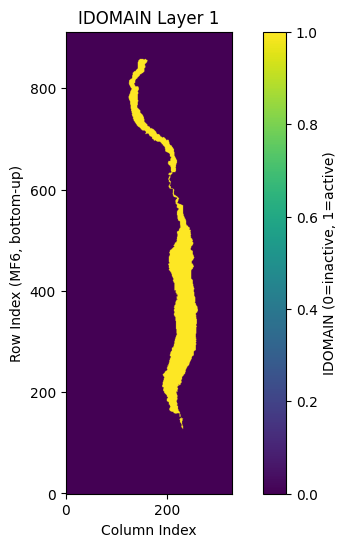

dis package written successfully.
dis package created. runtime: 5.97 seconds.


In [5]:
start_time = time.time()

# model setup
model_crs = 'epsg:26913'  # define coordinate reference system
xul = 251539.8073999998  # upper-left x coordinate in feet
yul = 3639665.581800001  # upper-left y coordinate in feet
angrot = 24.0  # grid rotation angle in degrees
nlay = 9  # number of layers
nrow_owhm = 912  # number of rows from OWHM
ncol_owhm = 328  # number of columns from OWHM
nrow = nrow_owhm  # set rows for model
ncol = ncol_owhm  # set columns for model
delr = np.full(ncol, 660.0)  # cell width along rows in feet
delc = np.full(nrow, 660.0)  # cell height along columns in feet
xll = 326161.8336 / 0.3048  # lower-left x origin in feet
yll = 3472061.7670000014 / 0.3048  # lower-left y origin in feet
theta = np.radians(angrot)  # convert rotation angle to radians

# data paths
top_file = '../owhm/model/2022/Data_Model_Arrays/layers/ElevFtDEMR.txt'  # path to top elevation file
bot_files = [  # list of bottom elevation files for each layer
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_RC2_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_USF1_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_USF2_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_MSF1_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_MSF2_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/TopLSF1_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_LSF2_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/TopBSMT_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/BaseBSMT_ft.txt',
]

# load top elevation data
try:
    top = np.loadtxt(top_file, dtype=float)
    if top.shape != (nrow, ncol):
        top = top.reshape(nrow, ncol)[:nrow, :ncol]
    top = np.flipud(top)  # flip to MF6 bottom-up
    top = np.ceil(top)  # round up to nearest whole number
    print(f"Top elevation range (feet): min={np.min(top):.2f}, max={np.max(top):.2f}")
except Exception as e:
    print(f"error: loading top - {e}. exiting.")
    sys.exit(1)

# load bottom elevation data
botm = np.zeros((nlay, nrow, ncol), dtype=float)
for lay, bot_file in enumerate(bot_files):
    try:
        data = np.loadtxt(bot_file, dtype=float)
        if data.shape != (nrow, ncol):
            data = data.reshape(nrow, ncol)[:nrow, :ncol]
        botm[lay] = np.flipud(data)  # flip to MF6 bottom-up
    except Exception as e:
        print(f"error: loading bot layer {lay} - {e}. exiting.")
        sys.exit(1)

# IBOUND file paths for each layer (0-based indexing for layers)
ibound_files = {
    0: '../owhm/model/2022/Data_Model_Arrays/layers/IBOUND/L1IBOUND.txt',
    1: '../owhm/model/2022/Data_Model_Arrays/layers/IBOUND/L2IBOUND.txt',
    2: '../owhm/model/2022/Data_Model_Arrays/layers/IBOUND/L3IBOUND.txt',
    3: '../owhm/model/2022/Data_Model_Arrays/layers/IBOUND/L4IBOUND.txt',
    4: '../owhm/model/2022/Data_Model_Arrays/layers/IBOUND/L5IBOUND.txt',
    5: '../owhm/model/2022/Data_Model_Arrays/layers/IBOUND/L6IBOUND.txt',
    6: '../owhm/model/2022/Data_Model_Arrays/layers/IBOUND/L7IBOUND.txt',
    7: '../owhm/model/2022/Data_Model_Arrays/layers/IBOUND/L8IBOUND.txt',
    8: '../owhm/model/2022/Data_Model_Arrays/layers/IBOUND/L9IBOUND.txt',
}

# initialize idomain as all zeros
idomain = np.zeros((nlay, nrow, ncol), dtype=int)
print(f"Initial idomain all zeros: {np.sum(idomain == 1)}/{nlay * nrow * ncol}")

# load IBOUND data for each layer
for lay, ibound_file in ibound_files.items():
    try:
        # load IBOUND (MF-OWHM top-down order)
        ibound = np.loadtxt(ibound_file, dtype=int)
        if ibound.shape != (nrow_owhm, ncol_owhm):
            ibound = ibound.reshape(nrow_owhm, ncol_owhm)[:nrow, :ncol]
        
        # flip to MF6 bottom-up order
        ibound = np.flipud(ibound)
        
        # set idomain: 1 where ibound == 1, 0 elsewhere
        idomain[lay] = np.where(ibound == 1, 1, 0)
        print(f"Layer {lay + 1} active cells (from IBOUND): {np.sum(idomain[lay] == 1)}/{nrow * ncol}")
    except Exception as e:
        print(f"error: loading IBOUND for layer {lay + 1} - {e}. exiting.")
        sys.exit(1)

# set idomain = 0 where botm == -99999
tolerance = 1e-6  # tolerance for -99999 check
for lay in range(nlay):
    invalid_cells = np.abs(botm[lay] - (-99999)) < tolerance
    if np.any(invalid_cells):
        idomain[lay] = np.where(invalid_cells, 0, idomain[lay])
        print(f"Layer {lay + 1} active cells (after -99999 set to 0): {np.sum(idomain[lay] == 1)}/{nrow * ncol}")

# diagnostic: report active cells
for lay in range(nlay):
    print(f"Layer {lay + 1}: idomain = 1 cells: {np.sum(idomain[lay] == 1)}/{nrow * ncol}")

# create dis package
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,  
    botm=botm,  
    idomain=idomain, 
    xorigin=xll,  
    yorigin=yll,  
    angrot=angrot,
    length_units="feet"
)

# diagnostic plot of idomain layer 1 to check orientation
plt.figure(figsize=(8, 6))
plt.imshow(idomain[0], cmap="viridis", origin="lower")  # origin="lower" for MF6 bottom-up
plt.colorbar(label="IDOMAIN (0=inactive, 1=active)")
plt.title("IDOMAIN Layer 1")
plt.xlabel("Column Index")
plt.ylabel("Row Index (MF6, bottom-up)")
plt.show()

dis.write()
print("dis package written successfully.")
print(f"dis package created. runtime: {time.time() - start_time:.2f} seconds.")

### export 9 individual grids

In [11]:
# Start time for tracking runtime
start_time = time.time()
# convert coordinates to meters for visualization (qgis expects meters)
# grid coordinates (cell centers)
x = (np.arange(ncol) + 0.5) * delr[0]  # x coordinates for cell centers
y = (np.arange(nrow) + 0.5) * delc[0]  # y coordinates for cell centers
X, Y = np.meshgrid(x, y)  # create 2d grid of x, y coordinates
X_rot = xll + X * np.cos(theta) - Y * np.sin(theta)  # rotate x coordinates
Y_rot = yll + X * np.sin(theta) + Y * np.cos(theta)  # rotate y coordinate
X_rot_m = X_rot * 0.3048  # convert x coordinates to meters
Y_rot_m = Y_rot * 0.3048  # convert y coordinates to meters
# Export grid to geopackage with 9 individual layers
points = [Point(x, y) for x, y in zip(X_rot_m.ravel(), Y_rot_m.ravel())]  # create point geometries in meters

for lay in range(nlay):
    data = []
    for row_mf6 in range(nrow):  # row_mf6 is 0-based, bottom-up (MF6 convention)
        row_owhm = nrow - row_mf6  # convert to 1-based, top-down (OWHM convention)
        for col_mf6 in range(ncol):  # col_mf6 is 0-based (MF6)
            col_owhm = col_mf6 + 1  # convert to 1-based (OWHM)
            data.append({
                'layer': lay,
                'row_mf6': row_mf6,
                'row_owhm': row_owhm,
                'col_mf6': col_mf6,
                'col_owhm': col_owhm,
                'idomain': idomain[lay, row_mf6, col_mf6],
                'top_ft': top[row_mf6, col_mf6] if lay == 0 else botm[lay - 1, row_mf6, col_mf6],  # top for layer 0, botm of layer above
                'botm_ft': botm[lay, row_mf6, col_mf6],
                'geometry': points[row_mf6 * ncol + col_mf6]
            })
    # Create GeoDataFrame for this layer
    grid_gdf = gpd.GeoDataFrame(data, crs=model_crs)
    # Export to a separate layer in the GeoPackage
    layer_name = f"layer_{lay + 1}"
    grid_gdf.to_file('./shps/grid.gpkg', driver='GPKG', layer=layer_name)
    print(f"Exported layer {lay + 1} to ./shps/grid.gpkg as {layer_name}")

print(f"Exported 9 individual grids, one for each layer in the ./shps/grid.gpkg file. Runtime: {time.time() - start_time:.2f} seconds.")

Exported layer 1 to ./shps/grid.gpkg as layer_1
Exported layer 2 to ./shps/grid.gpkg as layer_2
Exported layer 3 to ./shps/grid.gpkg as layer_3
Exported layer 4 to ./shps/grid.gpkg as layer_4
Exported layer 5 to ./shps/grid.gpkg as layer_5
Exported layer 6 to ./shps/grid.gpkg as layer_6
Exported layer 7 to ./shps/grid.gpkg as layer_7
Exported layer 8 to ./shps/grid.gpkg as layer_8
Exported layer 9 to ./shps/grid.gpkg as layer_9
Exported 9 individual grids, one for each layer in the ./shps/grid.gpkg file. Runtime: 33.12 seconds.


## check the dis grid

In [8]:
start_time = time.time()

# Output GeoPackage path
output_gpkg = './shps/individual_idomains.gpkg'

# Loop through each layer and create a GeoDataFrame
for lay in range(nlay):
    # Create a list to hold the data for this layer
    data = []
    
    # Generate points and attributes for each cell in the layer
    for row in range(nrow):
        for col in range(ncol):
            # Get the coordinates in meters (for QGIS visualization)
            x_m = X_rot_m[row, col]
            y_m = Y_rot_m[row, col]
            
            # Append data for this cell
            data.append({
                'layer': lay + 1,  # 1-based layer index for readability
                'row': row,        # 0-based row index (MF6 convention)
                'col': col,        # 0-based column index
                'idomain': idomain[lay, row, col],  # idomain value (-1, 0, or 1)
                'geometry': Point(x_m, y_m)         # Point geometry in meters
            })
    
    # Create GeoDataFrame for this layer
    layer_gdf = gpd.GeoDataFrame(data, crs=model_crs)
    
    # Write to GeoPackage (append each layer with a unique name)
    layer_name = f'layer_{lay + 1}_idomain'
    layer_gdf.to_file(output_gpkg, layer=layer_name, driver='GPKG')
    print(f"Exported idomain for layer {lay + 1} to {output_gpkg}, layer: {layer_name}")
    
    # Optional diagnostic: Print summary stats for this layer
    active_cells = np.sum(idomain[lay] == 1)
    inactive_cells = np.sum(idomain[lay] == 0)
    pass_through_cells = np.sum(idomain[lay] == -1)
    print(f"Layer {lay + 1} summary: active={active_cells}, inactive={inactive_cells}, pass-through={pass_through_cells}")

print(f"All 9 layers exported to {output_gpkg}. Runtime: {time.time() - start_time:.2f} seconds.")

NameError: name 'X_rot_m' is not defined

## oc 

In [5]:
# create oc (output control) package - defines output data to save or print
oc = flopy.mf6.ModflowGwfoc(
    gwf,  # link to groundwater flow model
    budget_filerecord=f'{sim_name}.cbc',  # set budget output file name - saves cell-by-cell budget data
    head_filerecord=f'{sim_name}.hds',  # set head output file name - saves head data
    headprintrecord=[('COLUMNS', 10, 'WIDTH', 15, 'DIGITS', 6, 'GENERAL')],  # define head printing format - columns, width, digits, and format type
    saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],  # save heads and budgets for all time steps - specifies data to save
    printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],  # print heads and budgets for all time steps - specifies data to print to listing file
)
print("oc package created.") 

oc package created.


## ims

In [6]:
# iterative model solutions package -- controls iterative solution of linear and nonlinear equations
#  controls solver settings
ims = flopy.mf6.ModflowIms(
    sim,  # link to simulation
    pname='ims',  # set package name
    complexity='simple',  # set solver complexity - uses simple defaults
    outer_dvclose=1e-4,  # set outer iteration closure criterion (head change)
    outer_maximum=500,  # set max number of outer iterations
    inner_maximum=100,  # set max number of inner iterations per outer iteration
    inner_dvclose=1e-4,  # set inner iteration closure criterion (head change)
    rcloserecord=0.001,  # set residual closure criterion for flow balance
    linear_acceleration='cg',  # set linear acceleration method - conjugate gradient
    relaxation_factor=0.97,  # set relaxation factor for solver stability
)
print("ims package created.")  

ims package created.


## ic

In [7]:
# key info: specifies initial heads for the model
# grid dimensions (from dis)
nlay = 9
nrow = 912
ncol = 328

# head file paths (relative to rgtihm-main/model)
head_files = [
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY1.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY2.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY3.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY4.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY5.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY6.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY7.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY8.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY9.txt',
]

default_head = 0.0
strt = np.ones((nlay, nrow, ncol), dtype=float) * default_head

# read heads into 3d array
for lay, head_file in enumerate(head_files):
    try:
        data = np.loadtxt(head_file, dtype=float)
        if data.shape != (nrow, ncol):
            print(f"warning: {head_file} shape {data.shape} != ({nrow}, {ncol})")
            data = data.reshape(nrow, ncol)[:nrow, :ncol]
        strt[lay] = data
    except FileNotFoundError:
        print(f"error: {head_file} not found. IC requires this file. Exiting.")
        raise FileNotFoundError(f"Error: {head_file} not found.")
    except Exception as e:
        print(f"error reading {head_file}: {e}. Exiting.")
        raise Exception(f"Error reading {head_file}: {e}")

# apply idomain from dis package
idomain = dis.idomain.array
mask_active = idomain == 1

# fix strt for active cells
top = dis.top.array
botm = dis.botm.array
for lay in range(nlay):
    active_mask = mask_active[lay]
    invalid_heads = (strt[lay] == -999) & active_mask
    if invalid_heads.any():
        default_head = (top[active_mask] + botm[lay][active_mask]) / 2 if lay == 0 else \
                       (botm[lay-1][active_mask] + botm[lay][active_mask]) / 2
        strt[lay][invalid_heads] = default_head[invalid_heads[active_mask]]
    strt[lay][active_mask] = np.clip(strt[lay][active_mask], botm[lay][active_mask], top[active_mask])

# verify strt
print("NaN in strt:", np.isnan(strt).any())
for lay in range(nlay):
    strt_active = strt[lay][mask_active[lay]]
    print(f"Layer {lay + 1} strt (active) min/max:", 
          strt_active.min() if len(strt_active) > 0 else "No active cells", 
          strt_active.max() if len(strt_active) > 0 else "No active cells")

# create ic package
ic = flopy.mf6.ModflowGwfic(gwf, strt=strt)
print(f"ic package created. runtime: {time.time() - start_time:.2f} seconds")
print("ic package created with -999 treated as nodata by applying idomain from .dis")

NaN in strt: False
Layer 1 strt (active) min/max: 3738.0040000000004 4142.873
Layer 2 strt (active) min/max: 3738.717 5101.0
Layer 3 strt (active) min/max: 3748.097 5096.0
Layer 4 strt (active) min/max: 3748.058 5092.0
Layer 5 strt (active) min/max: 3748.049 5089.0
Layer 6 strt (active) min/max: 3747.913 5087.0
Layer 7 strt (active) min/max: 3747.817 5084.0
Layer 8 strt (active) min/max: 3747.805 5082.0
Layer 9 strt (active) min/max: 3747.795 4831.84
ic package created. runtime: 44.79 seconds
ic package created with -999 treated as nodata by applying idomain from .dis


# wel (indlude all wells in all idomains)

In [34]:
# key info: specifies well locations and pumping rates

start_time = time.time()  # record start time
# dir
well_folder = '../owhm/model/2022/Data_FeedFiles/WEL'

# model setup (reused from DIS conversion)
model_crs = 'epsg:26913'  # UTM Zone 13N, NAD83
xul = 251539.8073999998  # upper-left x in feet
yul = 3639665.581800001  # upper-left y in feet
angrot = 24.0  # grid rotation angle in degrees
nlay = 9  # number of layers
nrow_owhm = 912  # number of rows from MF-OWHM
ncol_owhm = 328  # number of columns from MF-OWHM
nrow = nrow_owhm  # set rows for model
ncol = ncol_owhm  # set columns for model
delr = np.full(ncol, 660.0)  # cell width along rows in feet
delc = np.full(nrow, 660.0)  # cell height along columns in feet
xll = 326161.8336 / 0.3048  # lower-left x origin in feet
yll = 3472061.7670000014 / 0.3048  # lower-left y origin in feet
theta = np.radians(angrot)  # convert rotation angle to radians

# read well files
well_files = [f for f in os.listdir(well_folder) if f.endswith('_FEED.txt')]
print(f"found {len(well_files)} well files: {well_files}")

from multiprocessing import Pool

def is_float(value):
    # check if a string can be converted to float
    try:
        float(value)
        return True
    except ValueError:
        return False

def process_well_file(well_file):
    # process individual well file
    file_path = os.path.join(well_folder, well_file)
    temp_locations = []
    temp_flux = []
    reading_locations = True

    with open(file_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        if 'TEMPORAL INPUT' in line:
            reading_locations = False
            continue
        if reading_locations:
            if line.strip() and not line.startswith('#'):
                parts = line.split()
                layer_mf6 = int(parts[0]) - 1  # convert to 0-based
                row_mf6 = int(parts[1]) - 1    # convert to 0-based, assume already bottom-up
                col_mf6 = int(parts[2]) - 1    # convert to 0-based
                # validate bounds
                if layer_mf6 >= nlay or row_mf6 >= nrow or col_mf6 >= ncol:
                    print(f"warning: well {parts[3]} at mf6 ({layer_mf6}, {row_mf6}, {col_mf6}) "
                          f"exceeds grid dimensions ({nlay}, {nrow}, {ncol})")
                    continue
                well_name = parts[3].strip()
                temp_locations.append({
                    'layer_mf6': layer_mf6,
                    'row_mf6': row_mf6,
                    'col_mf6': col_mf6,
                    'name': well_name
                })
        else:
            if line.strip() and not line.startswith('#'):
                parts = line.split()
                flux = []
                for x in parts:
                    if not x.startswith('#') and is_float(x):
                        flux.append(float(x) if x.lower() != 'nan' else 0.0)
                if flux:
                    temp_flux.append(flux)

    # align flux data with locations
    if temp_flux:
        max_len = len(temp_locations)
        temp_flux = [f + [0.0] * (max_len - len(f)) if len(f) < max_len else f[:max_len] for f in temp_flux]
    else:
        temp_flux = [[0.0] * len(temp_locations) for _ in range(1)]  # at least one stress period

    unique_names_in_file = set(loc['name'] for loc in temp_locations)
    print(f"file: {well_file}, wells: {len(temp_locations)}, unique names: {unique_names_in_file}")
    return temp_locations, temp_flux

# use pool to parallelize file processing
with Pool() as p:
    results = p.map(process_well_file, well_files)

well_locations = []
flux_data = []
well_count = 0
current_well_count = 0

for temp_locations, temp_flux in results:
    well_locations.extend(temp_locations)
    new_well_count = len(temp_locations)
    if not flux_data:
        # initialize flux_data with the first temp_flux
        flux_data = [[0.0] * current_well_count + f for f in temp_flux]
    else:
        # pad existing flux_data and append new fluxes
        max_sp = max(len(flux_data), len(temp_flux))
        flux_data = [flux_data[i] + [0.0] * new_well_count if i < len(flux_data) else [0.0] * current_well_count + [0.0] * new_well_count for i in range(max_sp)]
        for i in range(len(temp_flux)):
            if i < len(flux_data):
                flux_data[i] = flux_data[i][:current_well_count] + temp_flux[i]
            else:
                flux_data.append([0.0] * current_well_count + temp_flux[i])
    current_well_count += new_well_count
    well_count += new_well_count

# identify wells outside idomain 1 (for reporting only)
comment_wells = set()
for i, well in enumerate(well_locations):
    if dis.idomain.array[well['layer_mf6'], well['row_mf6'], well['col_mf6']] != 1:
        comment_wells.add(i)
print(f"Number of wells outside idomain 1: {len(comment_wells)}")
print(f"Total wells: {well_count}")

print(f"Total flux data rows: {len(flux_data)}")
print("First 5 wells (MF6 indices):")
for well in well_locations[:5]:
    print(f"Well {well['name']}: MF6 ({well['layer_mf6']}, {well['row_mf6']}, {well['col_mf6']})")
unique_well_names = set(well['name'] for well in well_locations)
print(f"Combined unique well names: {unique_well_names}")

# prepare stress period data (include all wells)
stress_period_data = {}
previous_flux = None

for sp in range(min(nper, len(flux_data))):
    current_flux = flux_data[sp]
    if sp == 0 or current_flux != previous_flux:
        stress_period_data[sp] = []
        for idx, well in enumerate(well_locations):
            if idx < len(current_flux) and current_flux[idx] != 0.0:
                well_tuple = ((well['layer_mf6'], well['row_mf6'], well['col_mf6']), current_flux[idx], well['name'])
                stress_period_data[sp].append(well_tuple)
    previous_flux = current_flux

if not stress_period_data:
    raise ValueError("Error: stress_period_data is empty!")
else:
    for sp in range(min(nper, 5)):
        if sp in stress_period_data:
            print(f"Stress period {sp} data (MF6 indices): {stress_period_data[sp][:5]}")

# calculate MAXBOUND (maximum number of wells in any stress period)
maxbound = max(len(sp_data) for sp_data in stress_period_data.values()) if stress_period_data else 0
print(f"MAXBOUND (maximum number of wells in any stress period): {maxbound}")

# write the WEL package file directly (no commenting out wells)
wel_file = f"./model/{gwf.name}.wel"  # adjust path to model directory
with open(wel_file, 'w') as f:
    # write header
    f.write("# WEL package file generated (all wells included, no commenting)\n")
    f.write("BEGIN OPTIONS\n")
    f.write("  BOUNDNAMES\n")
    f.write("  SAVE_FLOWS\n")
    f.write("  PRINT_INPUT\n")
    f.write("END OPTIONS\n\n")

    # write dimensions block
    f.write("BEGIN DIMENSIONS\n")
    f.write(f"  MAXBOUND {maxbound}\n")
    f.write("END DIMENSIONS\n\n")

    # write stress period data
    for sp in range(min(nper, len(flux_data))):
        if sp in stress_period_data:
            f.write(f"BEGIN PERIOD {sp + 1}\n")
            for well_data in stress_period_data[sp]:
                cellid = well_data[0]  # (layer, row, col)
                flux = well_data[1]
                well_name = well_data[2]
                # write all wells without commenting
                line = f"  {cellid[0] + 1}  {cellid[1] + 1}  {cellid[2] + 1}  {flux}  {well_name}\n"
                f.write(line)
            f.write(f"END PERIOD {sp + 1}\n\n")

print(f"Wrote WEL package file to {wel_file} (all wells included, no commenting)")

# export wells to geopackage (include all wells)
# get grid information from DIS package
try:
    xll = float(dis.xorigin.data) if hasattr(dis.xorigin, 'data') else float(dis.xorigin)
except AttributeError:
    xll = float(dis.xorigin)
try:
    yll = float(dis.yorigin.data) if hasattr(dis.yorigin, 'data') else float(dis.yorigin)
except AttributeError:
    yll = float(dis.yorigin)
try:
    angrot = float(dis.angrot.data) if hasattr(dis.angrot, 'data') else float(dis.angrot)
except AttributeError:
    angrot = float(dis.angrot)

# use uniform delr and delc from DIS setup
delr = delr[0]  # uniform cell width
delc = delc[0]  # uniform cell height

# create a list of dictionaries for the GeoDataFrame
well_data = []
for idx, well in enumerate(well_locations):
    # compute x, y coordinates (center of cell) in model coordinate system (feet)
    x = xll + (well['col_mf6'] + 0.5) * delr
    y = yll + (nrow - 1 - well['row_mf6'] + 0.5) * delc  # adjust for bottom-up indexing
    
    # apply rotation
    theta = np.radians(angrot)
    x_rot = xll + (x - xll) * np.cos(theta) - (y - yll) * np.sin(theta)
    y_rot = yll + (x - xll) * np.sin(theta) + (y - yll) * np.cos(theta)
    x, y = x_rot, y_rot
    
    # convert to meters for geopackage export (QGIS expects meters)
    x_m = x * 0.3048
    y_m = y * 0.3048
    
    # collect attributes
    well_attrs = {
        'name': well['name'],
        'layer_mf6': well['layer_mf6'],
        'row_mf6': well['row_mf6'],
        'col_mf6': well['col_mf6'],
        'geometry': Point(x_m, y_m)
    }
    # add flux values for each stress period
    for sp in range(min(nper, len(flux_data))):
        flux = flux_data[sp][idx] if idx < len(flux_data[sp]) else 0.0
        well_attrs[f'flux_sp{sp}'] = flux
    well_data.append(well_attrs)

# create GeoDataFrame
gdf = gpd.GeoDataFrame(well_data, geometry='geometry')
gdf.crs = model_crs  # set CRS to match model (epsg:26913)

# export to geopackage
gdf.to_file('./shps/wells.gpkg', driver='GPKG', layer='wells')
print("Exported wells to wells.gpkg in the shps subdir")

# calculate and print runtime
end_time = time.time()
runtime = end_time - start_time
print(f"Script runtime: {runtime:.2f} seconds")

print("WEL package processing completed successfully.")

found 8 well files: ['TX_DOM_FEED.txt', 'NM_DOM_FEED.txt', 'MX_MnI_FEED.txt', 'NM_PDM_FEED.txt', 'NM_DCN_FEED.txt', 'NM_DOL_FEED.txt', 'NM_PDL_FEED.txt', 'NM_CLS_FEED.txt']


/usr/lib64/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=13362) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib64/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=13362) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib64/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=13362) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib64/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=13362) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib64/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=13362) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib64/python3.12/multiprocessi

file: NM_DCN_FEED.txt, wells: 3, unique names: {'WEL_DOM_NM'}
file: NM_PDL_FEED.txt, wells: 73, unique names: {'WEL_DOM_NM'}
file: MX_MnI_FEED.txt, wells: 33, unique names: {'WEL_MNI_MX'}
file: NM_CLS_FEED.txt, wells: 85, unique names: {'WEL_DOM_NM'}
file: TX_DOM_FEED.txt, wells: 60, unique names: {'WEL_DOM_TX'}
file: NM_DOL_FEED.txt, wells: 166, unique names: {'WEL_DOM_NM'}
file: NM_PDM_FEED.txt, wells: 1308, unique names: {'WEL_DOM_NM'}
file: NM_DOM_FEED.txt, wells: 7182, unique names: {'WEL_DOM_NM'}
Number of wells outside idomain 1: 3203
Total wells: 8910
Total flux data rows: 922
First 5 wells (MF6 indices):
Well WEL_DOM_TX: MF6 (0, 661, 232)
Well WEL_DOM_TX: MF6 (0, 664, 227)
Well WEL_DOM_TX: MF6 (0, 671, 217)
Well WEL_DOM_TX: MF6 (0, 673, 227)
Well WEL_DOM_TX: MF6 (0, 674, 216)
Combined unique well names: {'WEL_MNI_MX', 'WEL_DOM_TX', 'WEL_DOM_NM'}
Stress period 0 data (MF6 indices): [((0, 664, 227), -112.480197686, 'WEL_DOM_TX'), ((0, 671, 217), -112.480197686, 'WEL_DOM_TX'), ((

## wel (including but commenting out wells in idomain -1)

In [8]:

# key info: specifies well locations and pumping rates

start_time = time.time()  # record start time
# dir
well_folder = '../owhm/model/2022/Data_FeedFiles/WEL'

# model setup (reused from DIS conversion)
model_crs = 'epsg:26913'  # UTM Zone 13N, NAD83
xul = 251539.8073999998  # upper-left x in feet
yul = 3639665.581800001  # upper-left y in feet
angrot = 24.0  # grid rotation angle in degrees
nlay = 9  # number of layers
nrow_owhm = 912  # number of rows from MF-OWHM
ncol_owhm = 328  # number of columns from MF-OWHM
nrow = nrow_owhm  # set rows for model
ncol = ncol_owhm  # set columns for model
delr = np.full(ncol, 660.0)  # cell width along rows in feet
delc = np.full(nrow, 660.0)  # cell height along columns in feet
xll = 326161.8336 / 0.3048  # lower-left x origin in feet
yll = 3472061.7670000014 / 0.3048  # lower-left y origin in feet
theta = np.radians(angrot)  # convert rotation angle to radians

# read well files
well_files = [f for f in os.listdir(well_folder) if f.endswith('_FEED.txt')]
print(f"found {len(well_files)} well files: {well_files}")

from multiprocessing import Pool

def is_float(value):
    # check if a string can be converted to float
    try:
        float(value)
        return True
    except ValueError:
        return False

def process_well_file(well_file):
    # process individual well file
    file_path = os.path.join(well_folder, well_file)
    temp_locations = []
    temp_flux = []
    reading_locations = True

    with open(file_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        if 'TEMPORAL INPUT' in line:
            reading_locations = False
            continue
        if reading_locations:
            if line.strip() and not line.startswith('#'):
                parts = line.split()
                layer_mf6 = int(parts[0]) - 1  # convert to 0-based
                row_mf6 = int(parts[1]) - 1    # convert to 0-based, assume already bottom-up
                col_mf6 = int(parts[2]) - 1    # convert to 0-based
                # validate bounds
                if layer_mf6 >= nlay or row_mf6 >= nrow or col_mf6 >= ncol:
                    print(f"warning: well {parts[3]} at mf6 ({layer_mf6}, {row_mf6}, {col_mf6}) "
                          f"exceeds grid dimensions ({nlay}, {nrow}, {ncol})")
                    continue
                well_name = parts[3].strip()
                temp_locations.append({
                    'layer_mf6': layer_mf6,
                    'row_mf6': row_mf6,
                    'col_mf6': col_mf6,
                    'name': well_name
                })
        else:
            if line.strip() and not line.startswith('#'):
                parts = line.split()
                flux = []
                for x in parts:
                    if not x.startswith('#') and is_float(x):
                        flux.append(float(x) if x.lower() != 'nan' else 0.0)
                if flux:
                    temp_flux.append(flux)

    # align flux data with locations
    if temp_flux:
        max_len = len(temp_locations)
        temp_flux = [f + [0.0] * (max_len - len(f)) if len(f) < max_len else f[:max_len] for f in temp_flux]
    else:
        temp_flux = [[0.0] * len(temp_locations) for _ in range(1)]  # at least one stress period

    unique_names_in_file = set(loc['name'] for loc in temp_locations)
    print(f"file: {well_file}, wells: {len(temp_locations)}, unique names: {unique_names_in_file}")
    return temp_locations, temp_flux

# use pool to parallelize file processing
with Pool() as p:
    results = p.map(process_well_file, well_files)

well_locations = []
flux_data = []
well_count = 0
current_well_count = 0

for temp_locations, temp_flux in results:
    well_locations.extend(temp_locations)
    new_well_count = len(temp_locations)
    if not flux_data:
        # initialize flux_data with the first temp_flux
        flux_data = [[0.0] * current_well_count + f for f in temp_flux]
    else:
        # pad existing flux_data and append new fluxes
        max_sp = max(len(flux_data), len(temp_flux))
        flux_data = [flux_data[i] + [0.0] * new_well_count if i < len(flux_data) else [0.0] * current_well_count + [0.0] * new_well_count for i in range(max_sp)]
        for i in range(len(temp_flux)):
            if i < len(flux_data):
                flux_data[i] = flux_data[i][:current_well_count] + temp_flux[i]
            else:
                flux_data.append([0.0] * current_well_count + temp_flux[i])
    current_well_count += new_well_count
    well_count += new_well_count

# identify wells outside idomain 1 (for commenting)
comment_wells = set()
for i, well in enumerate(well_locations):
    if dis.idomain.array[well['layer_mf6'], well['row_mf6'], well['col_mf6']] != 1:
        comment_wells.add(i)
print(f"number of wells outside idomain 1 (to be commented out): {len(comment_wells)}")
print(f"total wells: {well_count}")

print(f"total flux data rows: {len(flux_data)}")
print("first 5 wells (MF6 indices):")
for well in well_locations[:5]:
    print(f"well {well['name']}: mf6 ({well['layer_mf6']}, {well['row_mf6']}, {well['col_mf6']})")
unique_well_names = set(well['name'] for well in well_locations)
print(f"combined unique well names: {unique_well_names}")

# prepare stress period data (include all wells)
stress_period_data = {}
previous_flux = None

for sp in range(min(nper, len(flux_data))):
    current_flux = flux_data[sp]
    if sp == 0 or current_flux != previous_flux:
        stress_period_data[sp] = []
        for idx, well in enumerate(well_locations):
            if idx < len(current_flux) and current_flux[idx] != 0.0:
                well_tuple = ((well['layer_mf6'], well['row_mf6'], well['col_mf6']), current_flux[idx], well['name'])
                stress_period_data[sp].append(well_tuple)
    previous_flux = current_flux

if not stress_period_data:
    raise ValueError("error: stress_period_data is empty!")
else:
    for sp in range(min(nper, 5)):
        if sp in stress_period_data:
            print(f"stress period {sp} data (mf6 indices): {stress_period_data[sp][:5]}")

# calculate MAXBOUND (maximum number of wells in any stress period)
maxbound = max(len(sp_data) for sp_data in stress_period_data.values()) if stress_period_data else 0
print(f"MAXBOUND (maximum number of wells in any stress period): {maxbound}")

# write the WEL package file directly with comments for wells outside idomain 1
wel_file = f"./model/{gwf.name}.wel"  # adjust path to model directory
with open(wel_file, 'w') as f:
    # write header
    f.write("# WEL package file generated with commented wells outside idomain 1\n")
    f.write("BEGIN OPTIONS\n")
    f.write("  BOUNDNAMES\n")
    f.write("  SAVE_FLOWS\n")
    f.write("  PRINT_INPUT\n")
    f.write("END OPTIONS\n\n")

    # write dimensions block
    f.write("BEGIN DIMENSIONS\n")
    f.write(f"  MAXBOUND {maxbound}\n")
    f.write("END DIMENSIONS\n\n")

    # write stress period data
    for sp in range(min(nper, len(flux_data))):
        if sp in stress_period_data:
            f.write(f"BEGIN PERIOD {sp + 1}\n")
            well_idx = -1
            for well_data in stress_period_data[sp]:
                well_idx += 1
                cellid = well_data[0]  # (layer, row, col)
                flux = well_data[1]
                well_name = well_data[2]
                # map back to well_locations index
                idx = None
                for i, well in enumerate(well_locations):
                    if (well['layer_mf6'] == cellid[0] and 
                        well['row_mf6'] == cellid[1] and 
                        well['col_mf6'] == cellid[2] and 
                        well['name'] == well_name):
                        idx = i
                        break
                if idx is None:
                    continue  # skip if not found
                # format the line
                line = f"  {cellid[0] + 1}  {cellid[1] + 1}  {cellid[2] + 1}  {flux}  {well_name}\n"
                # comment out if outside idomain 1
                if idx in comment_wells:
                    line = f"# {line.lstrip()}"
                f.write(line)
            f.write(f"END PERIOD {sp + 1}\n\n")

print(f"wrote WEL package file to {wel_file} with commented wells outside idomain 1")

# export wells to geopackage (include all wells)
# get grid information from DIS package
try:
    xll = float(dis.xorigin.data) if hasattr(dis.xorigin, 'data') else float(dis.xorigin)
except AttributeError:
    xll = float(dis.xorigin)
try:
    yll = float(dis.yorigin.data) if hasattr(dis.yorigin, 'data') else float(dis.yorigin)
except AttributeError:
    yll = float(dis.yorigin)
try:
    angrot = float(dis.angrot.data) if hasattr(dis.angrot, 'data') else float(dis.angrot)
except AttributeError:
    angrot = float(dis.angrot)

# use uniform delr and delc from DIS setup
delr = delr[0]  # uniform cell width
delc = delc[0]  # uniform cell height

# create a list of dictionaries for the GeoDataFrame
well_data = []
for idx, well in enumerate(well_locations):
    # compute x, y coordinates (center of cell) in model coordinate system (feet)
    x = xll + (well['col_mf6'] + 0.5) * delr
    y = yll + (nrow - 1 - well['row_mf6'] + 0.5) * delc  # adjust for bottom-up indexing
    
    # apply rotation
    theta = np.radians(angrot)
    x_rot = xll + (x - xll) * np.cos(theta) - (y - yll) * np.sin(theta)
    y_rot = yll + (x - xll) * np.sin(theta) + (y - yll) * np.cos(theta)
    x, y = x_rot, y_rot
    
    # convert to meters for geopackage export (QGIS expects meters)
    x_m = x * 0.3048
    y_m = y * 0.3048
    
    # collect attributes
    well_attrs = {
        'name': well['name'],
        'layer_mf6': well['layer_mf6'],
        'row_mf6': well['row_mf6'],
        'col_mf6': well['col_mf6'],
        'geometry': Point(x_m, y_m)
    }
    # add flux values for each stress period
    for sp in range(min(nper, len(flux_data))):
        flux = flux_data[sp][idx] if idx < len(flux_data[sp]) else 0.0
        well_attrs[f'flux_sp{sp}'] = flux
    well_data.append(well_attrs)

# create GeoDataFrame
gdf = gpd.GeoDataFrame(well_data, geometry='geometry')
gdf.crs = model_crs  # set CRS to match model (epsg:26913)

# export to geopackage
gdf.to_file('./shps/wells.gpkg', driver='GPKG', layer='wells')
print("exported wells to wells.gpkg in the shps subdir")

# calculate and print runtime
end_time = time.time()
runtime = end_time - start_time
print(f"Script runtime: {runtime:.2f} seconds")

print("wel package processing completed successfully.")

found 8 well files: ['TX_DOM_FEED.txt', 'NM_DOM_FEED.txt', 'MX_MnI_FEED.txt', 'NM_PDM_FEED.txt', 'NM_DCN_FEED.txt', 'NM_DOL_FEED.txt', 'NM_PDL_FEED.txt', 'NM_CLS_FEED.txt']


/usr/lib64/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=12815) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib64/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=12815) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib64/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=12815) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib64/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=12815) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib64/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=12815) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib64/python3.12/multiprocessi

file: NM_PDL_FEED.txt, wells: 73, unique names: {'WEL_DOM_NM'}


/usr/lib64/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=12815) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


file: NM_DOL_FEED.txt, wells: 166, unique names: {'WEL_DOM_NM'}
file: MX_MnI_FEED.txt, wells: 33, unique names: {'WEL_MNI_MX'}
file: NM_DCN_FEED.txt, wells: 3, unique names: {'WEL_DOM_NM'}
file: NM_CLS_FEED.txt, wells: 85, unique names: {'WEL_DOM_NM'}
file: TX_DOM_FEED.txt, wells: 60, unique names: {'WEL_DOM_TX'}
file: NM_PDM_FEED.txt, wells: 1308, unique names: {'WEL_DOM_NM'}
file: NM_DOM_FEED.txt, wells: 7182, unique names: {'WEL_DOM_NM'}
number of wells outside idomain 1 (to be commented out): 1442
total wells: 8910
total flux data rows: 922
first 5 wells (MF6 indices):
well WEL_DOM_TX: mf6 (0, 661, 232)
well WEL_DOM_TX: mf6 (0, 664, 227)
well WEL_DOM_TX: mf6 (0, 671, 217)
well WEL_DOM_TX: mf6 (0, 673, 227)
well WEL_DOM_TX: mf6 (0, 674, 216)
combined unique well names: {'WEL_DOM_TX', 'WEL_MNI_MX', 'WEL_DOM_NM'}
stress period 0 data (mf6 indices): [((0, 664, 227), -112.480197686, 'WEL_DOM_TX'), ((0, 671, 217), -112.480197686, 'WEL_DOM_TX'), ((0, 673, 227), -112.480197686, 'WEL_DOM_TX

## ghb

In [33]:
import flopy.mf6
import numpy as np
import re

# Model setup (reused from DIS conversion)
model_crs = 'epsg:26913'  # UTM Zone 13N, NAD83
xul = 251539.8073999998  # upper-left x in feet
yul = 3639665.581800001  # upper-left y in feet
angrot = 24.0  # grid rotation angle in degrees
nlay = 9  # number of layers
nrow_owhm = 912  # number of rows from MF-OWHM
ncol_owhm = 328  # number of columns from MF-OWHM
nrow = nrow_owhm  # set rows for model
ncol = ncol_owhm  # set columns for model
delr = np.full(ncol, 660.0)  # cell width along rows in feet
delc = np.full(nrow, 660.0)  # cell height along columns in feet
xll = 326161.8336 / 0.3048  # lower-left x origin in feet
yll = 3472061.7670000014 / 0.3048  # lower-left y origin in feet
theta = np.radians(angrot)  # convert rotation angle to radians

# OWHM GHB file path
owhm_ghb_file = "../owhm/model/2022/GHB/RGTIHM.GHB"

# Read the input GHB file
with open(owhm_ghb_file, 'r') as file:
    lines = file.readlines()

# Extract GHB data based on pattern matching
ghb_pattern = re.compile(
    r'^\d+\s+\d+\s+\d+\s+[0-9.]+\s+[0-9.]+\s+(GHB_(Filmore|EPNarrow|RinconAr|MXW|MXSW|MXS|MXSE)|Filmore|EPNarrow|RinconAr|MXW|MXSW|MXS|MXSE)', 
    re.IGNORECASE
)

ghb_data = []
unmatched_lines = []
for line in lines:
    if ghb_pattern.match(line.strip()):
        # Clean up extra spaces and handle comments
        if '!' in line:
            data_parts = line.split('!')[0].strip().split()
        else:
            data_parts = line.strip().split()

        if len(data_parts) >= 6:
            # Extract layer, row, column (convert to 0-based indexing for MODFLOW 6)
            lay = int(data_parts[0]) - 1  # Adjust for 0-based indexing
            row_owhm = int(data_parts[1])  # 1-based, top-down (OWHM)
            col = int(data_parts[2]) - 1   # Convert column to 0-based
            bhead = float(data_parts[3])   # Boundary head
            cond = float(data_parts[4])    # Conductance
            boundname = data_parts[5]      # Boundname (e.g., GHB_Filmore)

            # Convert row to MODFLOW 6 bottom-up convention
            row_mf6 = nrow - 1 - (row_owhm - 1)  # 0-based, bottom-up

            # Validate bounds against grid dimensions
            if lay >= nlay or row_mf6 >= nrow or col >= ncol or lay < 0 or row_mf6 < 0 or col < 0:
                print(f"warning: GHB cell at ({lay}, {row_mf6}, {col}) exceeds grid dimensions ({nlay}, {nrow}, {ncol})")
                unmatched_lines.append(line.strip())
                continue  # Skip invalid entries

            # Format for MODFLOW 6 GHB: [(lay, row, col), bhead, cond, iface, boundname]
            iface = 1  # Default IFACE value
            ghb_data.append([(lay, row_mf6, col), bhead, cond, iface, boundname])
        else:
            unmatched_lines.append(line.strip())  # Store lines with insufficient data
    else:
        unmatched_lines.append(line.strip())  # Store non-matching lines as metadata

# Check and print unmatched lines
if unmatched_lines:
    print("These lines were skipped (didn’t match the pattern or had incorrect format):")
    for unmatched in unmatched_lines[:5]:
        print(unmatched)
    print(f"Total unmatched lines: {len(unmatched_lines)}, they are the metadata in the OWHM GHB file from line 573 onwards.")
else:
    print("All lines from the GHB file were successfully parsed.")

# Validate GHB cells against idomain
invalid_ghb_cells = []
for ghb_entry in ghb_data:
    lay, row, col = ghb_entry[0]  # Extract (lay, row, col) from GHB entry
    if dis.idomain.array[lay, row, col] != 1:
        invalid_ghb_cells.append((lay, row, col, ghb_entry[4]))  # Include boundname (now index 4)
print(f"Number of GHB cells outside idomain 1: {len(invalid_ghb_cells)}")

# Apply GHB data to all stress periods (constant conditions across all periods)
nper = sim.tdis.nper.get_data()  # Extract integer value
stress_period_data = {k: ghb_data for k in range(nper)}

# Add GHB package to existing 'gwf' object
ghb = flopy.mf6.ModflowGwfghb(
    gwf,
    pname='ghb',
    maxbound=len(ghb_data),
    stress_period_data=stress_period_data,  # GHB data for all periods
    auxiliary=[("IFACE",)],                 # IFACE auxiliary variable
    boundnames=True,                        # Preserve boundnames
    print_input=True,                       # Print input to listing file
    save_flows=True,                        # Save flows to budget file
    filename="rgtihm.ghb"
)
print(f"GHB package added to GWF model with {len(ghb_data)} boundaries across {nper} stress periods.")

# Write the GHB package
ghb.write()
print("GHB package created.")


These lines were skipped (didn’t match the pattern or had incorrect format):
PARAMETER 10 546
BEGIN BUDGET_GROUPS
GHB_Filmore
GHB_EPNarrow
GHB_RinconAr
Total unmatched lines: 10035, they are the metadata in the OWHM GHB file from line 573 onwards.
Number of GHB cells outside idomain 1: 0
GHB package added to GWF model with 546 boundaries across 898 stress periods.
GHB package created.


## export ghb gpkg

In [ ]:
# Export GHB data to GeoPackage
delr = delr[0]  # Uniform cell width
delc = delc[0]  # Uniform cell height

ghb_gdf_data = []
for ghb_entry in ghb_data:
    (lay, row, col), bhead, cond, boundname = ghb_entry
    
    # Compute x, y coordinates in model system (feet)
    x = xll + (col + 0.5) * delr
    y = yll + (row + 0.5) * delc  # Row is in MF6 bottom-up convention
    
    # Apply rotation
    x_rot = xll + (x - xll) * np.cos(theta) - (y - yll) * np.sin(theta)
    y_rot = yll + (x - xll) * np.sin(theta) + (y - yll) * np.cos(theta)
    
    # Convert to meters
    x_m = x_rot * 0.3048
    y_m = y_rot * 0.3048
    
    # Collect attributes
    ghb_attrs = {
        'layer_mf6': lay,
        'row_mf6': row,
        'col_mf6': col,
        'bhead': bhead,
        'conductance': cond,
        'boundname': boundname,
        'geometry': Point(x_m, y_m)
    }
    ghb_gdf_data.append(ghb_attrs)

# Create and export GeoDataFrame
ghb_gdf = gpd.GeoDataFrame(ghb_gdf_data, geometry='geometry', crs=model_crs)
ghb_gdf.to_file('./shps/ghb.gpkg', driver='GPKG', layer='ghb')
print("Exported GHB locations to ./shps/ghb.gpkg")

## npf

In [12]:
# node property flow package for k and k33
# in our case, horizontal and vertical conductivity - k11 and k22 is k, and k33 is conductivity of third ellipsoid axis - k33 tensor component
# turns out that k11 = k22 = k33 = k; since it is isotropic. we're using hk and vk.

# procedure: initialize hk, k22, k33 with small default (1e-10), populate from pval_data using zones,
# replace -99999 with default_k in active cells, set inactive cells to -99999, ensure k > 0 for active cells
# why: modflow 6 needs positive k for active cells (idomain = 1), ignores inactive cells; avoids nan for compatibility

# Use same idomain as DIS, apply to hk, k22, k33 from zones and pval_data

# zone file paths (relative to rgtihm-main/model)
zone_files = {
    'znlayrc': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/RC1_zonecode.txt',
    'znlay3': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/USF1_zonecode.txt',
    'znlay4': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/USF2_zonecode.txt',
    'znlay5': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/MSF1_zonecode.txt',
    'znlay6': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/MSF2_zonecode.txt',
    'znlay7': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/LSF1_zonecode.txt',
    'znlay8': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/LSF2_zonecode.txt',
    'znlay9': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/BSMT_zonecodeS.txt',
}

# read zone arrays
zone_arrays = {}
for name, filepath in zone_files.items():
    try:
        data = np.loadtxt(filepath, dtype=int)
        if data.shape != (nrow, ncol):
            print(f"warning: {filepath} shape {data.shape} != ({nrow}, {ncol})")
            data = data.reshape(nrow, ncol)[:nrow, :ncol]
        zone_arrays[name] = data
    except Exception as e:
        print(f"error reading {filepath}: {e}. using default zone 1.")
        zone_arrays[name] = np.ones((nrow, ncol), dtype=int)

# layer-to-zone mapping
layer_zones = {
    0: 'znlayrc', 1: 'znlayrc', 2: 'znlay3', 3: 'znlay4',
    4: 'znlay5', 5: 'znlay6', 6: 'znlay7', 7: 'znlay8', 8: 'znlay9'
}

# pval_data for hydraulic conductivity (hk and vk)
pval_data = {
    'l1hk10': 100.0, 'l1hk20': 30.0, 'l1hk30': 0.2629016, 'l1hk51': 0.14489073,
    'l2hk10': 100.0, 'l2hk20': 30.0, 'l2hk30': 0.2629016, 'l2hk51': 0.14489073,
    'l3hk15': 100.0, 'l3hk25': 100.0, 'l3hk35': 9.2195476, 'l3hk50': 30.0, 'l3hk51': 6.4479888,
    'l3hk55': 1.0, 'l3hk60': 0.17476377, 'l3hk90': 0.01,
    'l4hk15': 100.0, 'l4hk25': 100.0, 'l4hk35': 9.2195476, 'l4hk50': 30.0, 'l4hk51': 6.4479888,
    'l4hk55': 1.0, 'l4hk60': 0.17476377, 'l4hk90': 0.01,
    'l5hk35': 30.0, 'l5hk50': 0.20053775, 'l5hk55': 0.66872867, 'l5hk65': 1.0, 'l5hk90': 0.016224702,
    'l5hk100': 0.035072631,
    'l6hk25': 100.0, 'l6hk35': 30.0, 'l6hk40': 3.9352467, 'l6hk50': 0.20053775, 'l6hk55': 0.66872867,
    'l6hk65': 1.0, 'l6hk90': 0.016224702, 'l6hk100': 0.035072631,
    'l7hk35': 1.0, 'l7hk40': 2.1805362, 'l7hk55': 0.1, 'l7hk65': 0.38348569, 'l7hk90': 0.1, 'l7hk100': 0.023773051,
    'l8hk35': 1.0, 'l8hk40': 2.1805362, 'l8hk55': 0.1, 'l8hk65': 0.38348569, 'l8hk90': 0.1, 'l8hk100': 0.023773051,
    'l9hk11': 0.008606693, 'l9hk21': 0.58382645, 'l9hk31': 0.0042014914, 'l9hk41': 0.17529754, 'l9hk56': 10.0,
    'l9hk61': 0.048328901, 'l9hk71': 3.2559841,
    # vertical k (vk) for k33
    'l1vk10': 1.091422, 'l1vk20': 1.2296545, 'l1vk30': 155.00641, 'l1vk51': 1003.4731,
    'l2vk10': 1.091422, 'l2vk20': 1.2296545, 'l2vk30': 155.00641, 'l2vk51': 1003.4731,
    'l3vk15': 1.0, 'l3vk25': 10.413017, 'l3vk35': 5.2372343, 'l3vk50': 6.9875221, 'l3vk51': 8.741806,
    'l3vk55': 1358.6343, 'l3vk60': 1.0, 'l3vk90': 9.1188492,
    'l4vk15': 1.0, 'l4vk25': 10.413017, 'l4vk35': 5.2372343, 'l4vk50': 6.9875221, 'l4vk51': 8.741806,
    'l4vk55': 1358.6343, 'l4vk60': 1.0, 'l4vk90': 9.1188492,
    'l5vk35': 1.0, 'l5vk50': 5845.6619, 'l5vk55': 11.489684, 'l5vk65': 17.306335, 'l5vk90': 112.8303,
    'l5vk100': 10.288813,
    'l6vk25': 4.4199196, 'l6vk35': 1.0, 'l6vk40': 247.36765, 'l6vk50': 5845.6619, 'l6vk55': 11.489684,
    'l6vk65': 17.306335, 'l6vk90': 112.8303, 'l6vk100': 10.288813,
    'l7vk35': 2.7818614, 'l7vk40': 2.3683035, 'l7vk55': 1.2711653, 'l7vk65': 11.44632, 'l7vk90': 1.0,
    'l7vk100': 597.30784,
    'l8vk35': 2.7818614, 'l8vk40': 2.3683035, 'l8vk55': 1.2711653, 'l8vk65': 11.44632, 'l8vk90': 1.0,
    'l8vk100': 597.30784,
    'l9vk11': 1.0, 'l9vk21': 48.550788, 'l9vk31': 2.7429583, 'l9vk41': 1.9085057, 'l9vk56': 29.289344,
    'l9vk61': 1.0, 'l9vk71': 10000.0,
}

# initialize arrays with a small positive default for active cells
default_k = 1e-10  # MODFLOW requires k > 0 for active cells
hk = np.ones((nlay, nrow, ncol), dtype=float) * default_k
k22 = hk.copy()  # isotropic: k22 = hk unless specified
k33 = hk.copy()  # vertical k, defaults to hk unless vk provided
icelltype = [0] * nlay  # confined by default

# populate hk, k22, k33 from pval_data using zones
for param, value in pval_data.items():
    lay = int(param[1]) - 1  # layer index (0-based)
    iz = int(param.split('hk' if 'hk' in param else 'vk')[1])  # zone number
    zone_array = zone_arrays[layer_zones[lay]]
    mask = (zone_array == iz)
    if 'hk' in param:
        hk[lay][mask] = value
        k22[lay][mask] = value  # isotropic assumption
    elif 'vk' in param:
        k33[lay][mask] = value

# apply idomain from DIS package (already has global + layer masks + -99999 check)
idomain = dis.idomain.array
for lay in range(nlay):
    active_mask = idomain[lay] == 1
    # ensure active cells have k > 0
    hk[lay][active_mask] = np.maximum(hk[lay][active_mask], default_k)
    k22[lay][active_mask] = np.maximum(k22[lay][active_mask], default_k)
    k33[lay][active_mask] = np.maximum(k33[lay][active_mask], default_k)
    # inactive cells can keep default_k (MODFLOW ignores them)

# create NPF package
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    save_flows=True,
    icelltype=icelltype,
    k=hk,
    k22=k22,
    k33=k33,
    save_specific_discharge=True,
    alternative_cell_averaging="harmonic",
)
print(f"npf package created. runtime: {time.time() - start_time:.2f} seconds")
print("applied compound idomains, global and local for each layer. \nnpf package created from zonecode files and pvl/rgtihm.pvl")

npf package created. runtime: 1321.91 seconds
applied compound idomains, global and local for each layer. 
npf package created from zonecode files and pvl/rgtihm.pvl


## sto

In [13]:
## sto package

# no NaN: Replaced np.nan with defaults (ss_base = 0.000001 for SS, sy_base = 0.30 for SY) in active cells
# sentinel: Used -99999 for inactive cells (IDOMAIN = 0) instead of NaN    # dropped this method, it turned out to be idomain issue 
# defaults: Applied ss_base, sy_base where -99999 in pval_data/mult/thk for active cells, DEFAULT_MULT = 1.0 for missing mult
# validation: Ensured SS > 0, 0 <= SY <= 1 for active cells with np.maximum, np.clip
# use same idomain as DIS, apply multipliers and thickness, no sentinel values

# multiplier and thickness file paths (relative to rgtihm-main/model)
mult_files = {
    'uc_rc': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/RC1_UC.txt',
    'uc_usf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/USF1_UC.txt',
    'cf_usf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/USF1_CF.txt',
    'uc_msf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/MSF1_UC.txt',
    'cf_msf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/MSF1_CF.txt',
    'uc_lsf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/LSF1_UC.txt',
    'cf_lsf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/LSF1_CF.txt',
    'uc_bd': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/BSMT_UC.txt',
    'cf_bd': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/BSMT_CF.txt',
    'thk_rc1': '../owhm/model/2022/Data_Model_Arrays/layers/Geometry/THK_RC1_ft.txt',
    'thk_usf1': '../owhm/model/2022/Data_Model_Arrays/layers/Geometry/THK_USF1_ft.txt',
    'thk_msf1': '../owhm/model/2022/Data_Model_Arrays/layers/Geometry/THK_MSF1_ft.txt',
    'thk_lsf1': '../owhm/model/2022/Data_Model_Arrays/layers/Geometry/THK_LSF1_ft.txt',
    'thk_bd': '../owhm/model/2022/Data_Model_Arrays/layers/Geometry/THK_BSMT_ft.txt',
}

# read multiplier and thickness arrays
mult_arrays = {}
default_mult = 1.0  # default multiplier if missing
for name, filepath in mult_files.items():
    try:
        data = np.loadtxt(filepath, dtype=float)
        if data.shape != (nrow, ncol):
            print(f"warning: {filepath} shape {data.shape} != ({nrow}, {ncol})")
            data = data.reshape(nrow, ncol)[:nrow, :ncol]
        # convert thickness from ft to m, no sentinel needed
        data = data * 0.3048 if 'thk' in name else data
        mult_arrays[name] = data
    except Exception as e:
        print(f"error reading {filepath}: {e}. using default 1.0.")
        mult_arrays[name] = np.ones((nrow, ncol), dtype=float) * default_mult

# constants
ss_base = 0.000001  # default specific storage (1/m)
sy_base = 0.30      # default specific yield
phi = {'rc': 0.25, 'us': 0.22, 'ms': 0.12, 'ls': 0.08, 'bd': 0.07}  # porosity by layer group
comp_h2o = 1.432195e-06  # water compressibility (1/m)
offset = 0.0001  # avoid division by zero

# zone file paths (explicitly load here)
zone_files = {
    'znlayrc': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/RC1_zonecode.txt',
    'znlay3': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/USF1_zonecode.txt',
    'znlay4': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/USF2_zonecode.txt',
    'znlay5': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/MSF1_zonecode.txt',
    'znlay6': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/MSF2_zonecode.txt',
    'znlay7': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/LSF1_zonecode.txt',
    'znlay8': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/LSF2_zonecode.txt',
    'znlay9': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/BSMT_zonecodeS.txt',
}

# load zone arrays
zone_arrays = {}
for name, filepath in zone_files.items():
    try:
        data = np.loadtxt(filepath, dtype=int)
        if data.shape != (nrow, ncol):
            print(f"warning: {filepath} shape {data.shape} != ({nrow}, {ncol})")
            data = data.reshape(nrow, ncol)[:nrow, :ncol]
        zone_arrays[name] = data
    except Exception as e:
        print(f"error reading {filepath}: {e}. using default zone 1.")
        zone_arrays[name] = np.ones((nrow, ncol), dtype=int)

# layer-to-zone mapping
layer_zones = {
    0: 'znlayrc', 1: 'znlayrc', 2: 'znlay3', 3: 'znlay4',
    4: 'znlay5', 5: 'znlay6', 6: 'znlay7', 7: 'znlay8', 8: 'znlay9'
}

# pval_data for storage
pval_data = {
    'l2ss10': 5.0, 'l2ss20': 25.0, 'l2ss30': 8.2691995, 'l2ss51': 8.758604,
    'l3ss15': 1.0955468, 'l3ss25': 2.9409115, 'l3ss35': 3.33, 'l3ss50': 1.069701, 'l3ss51': 2.0, 'l3ss55': 10.0,
    'l3ss60': 5.1091253, 'l3ss90': 6.5520935,
    'l4ss15': 1.0955468, 'l4ss25': 2.9409115, 'l4ss35': 3.33, 'l4ss50': 1.069701, 'l4ss51': 2.0, 'l4ss55': 10.0,
    'l4ss60': 5.1091253, 'l4ss90': 6.5520935,
    'l5ss35': 0.4, 'l5ss50': 0.80498139, 'l5ss55': 1.104017, 'l5ss65': 0.5723319, 'l5ss90': 0.71704178,
    'l5ss100': 1.67,
    'l6ss25': 1.67, 'l6ss35': 0.4, 'l6ss40': 0.95152044, 'l6ss50': 0.80498139, 'l6ss55': 1.104017, 'l6ss65': 0.5723319,
    'l6ss90': 0.71704178, 'l6ss100': 1.67,
    'l7ss35': 1.2993514, 'l7ss40': 2.33, 'l7ss55': 2.33, 'l7ss65': 2.050916, 'l7ss90': 0.91998654, 'l7ss100': 1.4320346,
    'l8ss35': 1.2993514, 'l8ss40': 2.33, 'l8ss55': 2.33, 'l8ss65': 2.050916, 'l8ss90': 0.91998654, 'l8ss100': 1.4320346,
    'l9ss11': 2.33, 'l9ss21': 2.33, 'l9ss31': 0.88759879, 'l9ss41': 0.91689225, 'l9ss56': 0.667, 'l9ss61': 1.8936826,
    'l9ss71': 2.33,
    'l1sy10': 1.0, 'l1sy20': 1.0, 'l1sy30': 0.825, 'l1sy51': 1.0,
    'l3sy15': 0.50864162, 'l3sy25': 0.87375378, 'l3sy35': 0.59566227, 'l3sy50': 0.553, 'l3sy51': 0.29098953,
    'l3sy55': 0.73273826, 'l3sy60': 0.37109912, 'l3sy90': 0.2,
    'l5sy35': 0.536, 'l5sy50': 0.83810284, 'l5sy55': 1.0, 'l5sy65': 1.0, 'l5sy90': 0.51269604, 'l5sy100': 0.333,
    'l7sy35': 0.59566227, 'l7sy40': 0.88904665, 'l7sy55': 0.64751193, 'l7sy65': 0.83651446, 'l7sy90': 0.44452383,
    'l7sy100': 0.44452383,
    'l9sy11': 0.74220455, 'l9sy21': 0.333, 'l9sy31': 0.89490974, 'l9sy41': 0.87571372, 'l9sy56': 0.39531322,
    'l9sy61': 1.0, 'l9sy71': 1.0,
}

# initialize arrays with defaults for active cells
ss = np.ones((nlay, nrow, ncol), dtype=float) * ss_base
sy = np.ones((nlay, nrow, ncol), dtype=float) * sy_base
iconvert = [0] * nlay  # confined by default (adjust if needed)

# populate ss and sy with pval values
for param, value in pval_data.items():
    lay = int(param[1]) - 1
    iz = int(param.split('ss' if 'ss' in param else 'sy')[1])
    zone_array = zone_arrays[layer_zones[lay]]
    mask = (zone_array == iz)
    if 'ss' in param:
        ss[lay][mask] = value
    elif 'sy' in param:
        sy[lay][mask] = value

# apply multipliers and thickness (no sentinel values)
for lay in range(nlay):
    if lay in [0, 1]:  # rc
        thk = mult_arrays['thk_rc1']
        uc = mult_arrays['uc_rc']
        ss[lay] = np.maximum(ss[lay], (phi['rc'] * comp_h2o + ss_base) * uc)
        sy[lay] = np.clip((sy_base / (thk + offset) + phi['rc'] * comp_h2o) * uc, 0.0, 1.0)
    elif lay in [2, 3]:  # usf
        thk = mult_arrays['thk_usf1']
        uc = mult_arrays['uc_usf1']
        cf = mult_arrays['cf_usf1']
        ss[lay] = np.maximum(ss[lay], 
                             (phi['us'] * comp_h2o + ss_base) * (cf + uc) if lay == 3 else 
                             (phi['us'] * comp_h2o) * cf + ss_base * cf)
        sy[lay] = np.clip((sy_base / (thk + offset) + phi['us'] * comp_h2o) * uc, 0.0, 1.0)
    elif lay in [4, 5]:  # msf
        thk = mult_arrays['thk_msf1']
        uc = mult_arrays['uc_msf1']
        cf = mult_arrays['cf_msf1']
        ss[lay] = np.maximum(ss[lay], 
                             (phi['ms'] * comp_h2o + ss_base) * (cf + uc) if lay == 5 else 
                             (phi['ms'] * comp_h2o) * cf + ss_base * cf)
        sy[lay] = np.clip((sy_base / (thk + offset) + phi['ms'] * comp_h2o) * uc, 0.0, 1.0)
    elif lay in [6, 7]:  # lsf
        thk = mult_arrays['thk_lsf1']
        uc = mult_arrays['uc_lsf1']
        cf = mult_arrays['cf_lsf1']
        ss[lay] = np.maximum(ss[lay], 
                             (phi['ls'] * comp_h2o + ss_base) * (cf + uc) if lay == 7 else 
                             (phi['ls'] * comp_h2o) * cf + ss_base * cf)
        sy[lay] = np.clip((sy_base / (thk + offset) + phi['ls'] * comp_h2o) * uc, 0.0, 1.0)
    elif lay == 8:  # bd
        thk = mult_arrays['thk_bd']
        uc = mult_arrays['uc_bd']
        cf = mult_arrays['cf_bd']
        ss[lay] = np.maximum(ss[lay], (phi['bd'] * comp_h2o + ss_base) * (cf + uc))
        sy[lay] = np.clip((sy_base / (thk + offset) + phi['bd'] * comp_h2o) * uc, 0.0, 1.0)

# apply idomain from DIS package
idomain = dis.idomain.array
mask_active = idomain == 1

# ensure active cells have valid values
ss[mask_active] = np.maximum(ss[mask_active], ss_base)  # ss > 0
sy[mask_active] = np.clip(sy[mask_active], 0.0, 1.0)   # 0 <= sy <= 1
# inactive cells keep defaults (MODFLOW ignores them)

# verify
print("ss min/max (active):", ss[mask_active].min(), ss[mask_active].max())
print("sy min/max (active):", sy[mask_active].min(), sy[mask_active].max())

# create STO package
sto = flopy.mf6.ModflowGwfsto(
    gwf,
    save_flows=True,
    iconvert=iconvert,
    ss=ss,
    sy=sy,
    transient=True,
)
print(f"sto package created. runtime: {time.time() - start_time:.2f} seconds")
print("sto package created with -99999 replaced by compound idomains (global and local for each layer), -99999 for inactive cells.\nsto package created")

ss min/max (active): 1e-06 25.0
sy min/max (active): 0.0 0.9839293289640887
sto package created. runtime: 1323.70 seconds
sto package created with -99999 replaced by compound idomains (global and local for each layer), -99999 for inactive cells.
sto package created


## hfb orig

In [ ]:
# input file from OWHM
input_hfb_path = '../owhm/model/2022/HFB/RGTIHM.HFB'

tdis = sim.tdis
num_stress_periods = tdis.nper.array

# read and process the HFB file
with open(input_hfb_path, 'r') as file:
    hfb_data = file.readlines()

# dictionary to store HFB datasets
hfb_datasets = {}
current_dataset = None
current_entries = []

for line in hfb_data:
    line = line.strip()
    if not line or line.startswith(('12', 'NOPRINT')):
        continue
    
    # check if line is a dataset header
    if any(line.startswith(prefix) for prefix in ['LSF_N', 'LSF_NWNE', 'MSF_N', 'MSF_NWNE', 'PSF_NWNE', 
                                                 'Qb_MesC', 'Qb_MesE', 'Qb_MesW', 'Qb_MxW', 
                                                 'USF_N', 'USF_NWNE', 'MSF_RinMes']):
        if current_dataset and current_entries:
            hfb_datasets[current_dataset] = current_entries
        current_dataset = ' '.join(line.split()[:2])  # e.g., "LSF_N HFB"
        current_entries = []
    elif len(line.split()) == 6:  # data line with 6 columns
        current_entries.append(line)

# save the last dataset
if current_dataset and current_entries:
    hfb_datasets[current_dataset] = current_entries

# calculate total number of HFB entries
maxhfb_valid = sum(len(entries) for entries in hfb_datasets.values())

# prepare HFB data for MODFLOW 6
hfb_data_list = []
idomain = dis.idomain.array  # From DIS package
for dataset_name, entries in hfb_datasets.items():
    for entry in entries:
        parts = entry.split()
        if len(parts) != 6:
            print(f"warning: skipping malformed line in {dataset_name}: {entry}")
            continue
        # format: [layer1, row1, col1, layer2, row2, col2, hydchr]
        layer1 = int(parts[0]) - 1  # 0-based
        row1 = int(parts[1]) - 1
        col1 = int(parts[2]) - 1
        row2 = int(parts[3]) - 1
        col2 = int(parts[4]) - 1
        hydchr = float(parts[5])
        layer2 = layer1  # Assume same layer (OWHM HFB convention)
        # check if both cells are active
        if (idomain[layer1, row1, col1] > 0 and idomain[layer2, row2, col2] > 0):
            hfb_data_list.append([layer1, row1, col1, layer2, row2, col2, hydchr])

# create HFB package
hfb = flopy.mf6.ModflowGwfhfb(
    gwf,
    print_input=True,
    maxhfb=len(hfb_data_list),
    stress_period_data={period: hfb_data_list for period in range(num_stress_periods)}
)

print(f"hfb package created with {len(hfb_data_list)} barriers. runtime: {time.time() - start_time:.2f} seconds")

## hfb owhm idxing

In [16]:
import flopy.mf6
import time

start_time = time.time()

# Input file from OWHM
input_hfb_path = '../owhm/model/2022/HFB/RGTIHM.HFB'

tdis = sim.tdis
num_stress_periods = tdis.nper.array

# Read and process the HFB file
with open(input_hfb_path, 'r') as file:
    hfb_data = file.readlines()

# Dictionary to store HFB datasets
hfb_datasets = {}
current_dataset = None
current_entries = []

for line in hfb_data:
    line = line.strip()
    if not line or line.startswith(('12', 'NOPRINT')):
        continue
    
    if any(line.startswith(prefix) for prefix in ['LSF_N', 'LSF_NWNE', 'MSF_N', 'MSF_NWNE', 'PSF_NWNE', 
                                                 'Qb_MesC', 'Qb_MesE', 'Qb_MesW', 'Qb_MxW', 
                                                 'USF_N', 'USF_NWNE', 'MSF_RinMes']):
        if current_dataset and current_entries:
            hfb_datasets[current_dataset] = current_entries
        current_dataset = ' '.join(line.split()[:2])
        current_entries = []
    elif len(line.split()) == 6:
        current_entries.append(line)

if current_dataset and current_entries:
    hfb_datasets[current_dataset] = current_entries

maxhfb_valid = sum(len(entries) for entries in hfb_datasets.values())

# Prepare HFB data for OWHM convention (top-down, 0-based)
hfb_data_list_owhm = []
idomain = dis.idomain.array
for dataset_name, entries in hfb_datasets.items():
    for entry in entries:
        parts = entry.split()
        if len(parts) != 6:
            print(f"warning: skipping malformed line in {dataset_name}: {entry}")
            continue
        # Keep OWHM top-down convention (just shift to 0-based)
        layer1 = int(parts[0]) - 1
        row1_owhm = int(parts[1]) - 1  # 0-based, top-down
        col1 = int(parts[2]) - 1
        row2_owhm = int(parts[3]) - 1  # 0-based, top-down
        col2 = int(parts[4]) - 1
        hydchr = float(parts[5])
        layer2 = layer1
        
        if (idomain[layer1, row1_owhm, col1] > 0 and idomain[layer2, row2_owhm, col2] > 0):
            hfb_data_list_owhm.append([layer1, row1_owhm, col1, layer2, row2_owhm, col2, hydchr])

# Create HFB package (OWHM convention)
hfb_owhm = flopy.mf6.ModflowGwfhfb(
    gwf,
    print_input=True,
    maxhfb=len(hfb_data_list_owhm),
    stress_period_data={period: hfb_data_list_owhm for period in range(num_stress_periods)},
    filename="hfb_owhm.hfb"  # Unique filename to distinguish
)

print(f"HFB package (OWHM convention) created with {len(hfb_data_list_owhm)} barriers. Runtime: {time.time() - start_time:.2f} seconds")

HFB package (OWHM convention) created with 12181 barriers. Runtime: 293.08 seconds


## hfb mf6 idxing

In [35]:
import flopy.mf6
import time

start_time = time.time()

print("Starting HFB package creation.....")

# Input file from OWHM
input_hfb_path = '../owhm/model/2022/HFB/RGTIHM.HFB'

print(f"Reading HFB input file from {input_hfb_path}.....")

tdis = sim.tdis
num_stress_periods = tdis.nper.array
nrow = dis.nrow.get_data()  # Extract integer value from MFScalar

# Read and process the HFB file
with open(input_hfb_path, 'r') as file:
    hfb_data = file.readlines()

print(f"Processing {len(hfb_data)} lines from HFB file.....")

# Dictionary to store HFB datasets
hfb_datasets = {}
current_dataset = None
current_entries = []

for line in hfb_data:
    line = line.strip()
    if not line or line.startswith(('12', 'NOPRINT')):
        continue
    
    if any(line.startswith(prefix) for prefix in ['LSF_N', 'LSF_NWNE', 'MSF_N', 'MSF_NWNE', 'PSF_NWNE', 
                                                 'Qb_MesC', 'Qb_MesE', 'Qb_MesW', 'Qb_MxW', 
                                                 'USF_N', 'USF_NWNE', 'MSF_RinMes']):
        if current_dataset and current_entries:
            hfb_datasets[current_dataset] = current_entries
        current_dataset = ' '.join(line.split()[:2])
        current_entries = []
    elif len(line.split()) == 6:
        current_entries.append(line)

if current_dataset and current_entries:
    hfb_datasets[current_dataset] = current_entries

maxhfb_valid = sum(len(entries) for entries in hfb_datasets.values())

print(f"Found {len(hfb_datasets)} HFB datasets with {maxhfb_valid} total barriers.....")

# Prepare HFB data for MODFLOW 6 (bottom-up convention)
hfb_data_list = []
idomain = dis.idomain.array
print("Converting HFB data to MODFLOW 6 format and validating against idomain.....")
for dataset_name, entries in hfb_datasets.items():
    for entry in entries:
        parts = entry.split()
        if len(parts) != 6:
            print(f"warning: skipping malformed line in {dataset_name}: {entry}")
            continue
        # Convert from OWHM (1-based, top-down) to MF6 (0-based, bottom-up)
        layer1 = int(parts[0]) - 1  # 0-based layer
        row1_owhm = int(parts[1])   # 1-based, top-down (OWHM)
        col1 = int(parts[2]) - 1    # 0-based column
        row2_owhm = int(parts[3])   # 1-based, top-down (OWHM)
        col2 = int(parts[4]) - 1    # 0-based column
        hydchr = float(parts[5])
        layer2 = layer1
        
        # Convert rows to MF6 convention
        row1_mf6 = nrow - 1 - (row1_owhm - 1)  # Invert to bottom-up
        row2_mf6 = nrow - 1 - (row2_owhm - 1)  # Invert to bottom-up
        
        if (idomain[layer1, row1_mf6, col1] > 0 and idomain[layer2, row2_mf6, col2] > 0):
            hfb_data_list.append([layer1, row1_mf6, col1, layer2, row2_mf6, col2, hydchr])

print(f"Prepared {len(hfb_data_list)} valid HFB barriers after idomain check.....")

# Create HFB package
print("Creating HFB package for MODFLOW 6.....")
hfb = flopy.mf6.ModflowGwfhfb(
    gwf,
    print_input=True,
    maxhfb=len(hfb_data_list),
    stress_period_data={period: hfb_data_list for period in range(num_stress_periods)},
    filename="rgtihm.hfb"
)

print(f"HFB package created with {len(hfb_data_list)} barriers. Runtime: {time.time() - start_time:.2f} seconds")

# Write package
print("Writing HFB package to rgtihm.hfb.....")
hfb.write()

print("HFB package writing completed")

Starting HFB package creation.....
Reading HFB input file from ../owhm/model/2022/HFB/RGTIHM.HFB.....
Processing 46619 lines from HFB file.....
Found 12 HFB datasets with 34932 total barriers.....
Converting HFB data to MODFLOW 6 format and validating against idomain.....
Prepared 34932 valid HFB barriers after idomain check.....
Creating HFB package for MODFLOW 6.....
HFB package created with 34932 barriers. Runtime: 1228.49 seconds
Writing HFB package to rgtihm.hfb.....
HFB package writing completed


## export the hfb points
for visual diagnostic

In [36]:
# export HFB data to GeoPackage
from shapely.geometry import LineString

# get cell center coordinates in meters (from your DIS setup)
points = [Point(x, y) for x, y in zip(X_rot_m.ravel(), Y_rot_m.ravel())]  # from your grid setup

# prepare HFB data for export
hfb_export_data = []
for i, barrier in enumerate(hfb_data_list):
    layer1, row1, col1, layer2, row2, col2, hydchr = barrier
    
    # get coordinates for cell 1 and cell 2
    idx1 = row1 * ncol + col1
    idx2 = row2 * ncol + col2
    x1, y1 = points[idx1].x, points[idx1].y
    x2, y2 = points[idx2].x, points[idx2].y
    
    # create a line geometry between the two cells
    line = LineString([(x1, y1), (x2, y2)])
    
    # store data
    hfb_export_data.append({
        'barrier_id': i,
        'layer1': layer1,
        'row1': row1,
        'col1': col1,
        'layer2': layer2,
        'row2': row2,
        'col2': col2,
        'hydchr': hydchr,
        'geometry': line
    })

# create GeoDataFrame
hfb_gdf = gpd.GeoDataFrame(hfb_export_data, crs=model_crs)

# export to GeoPackage
output_path = './shps/hfb.gpkg'
hfb_gdf.to_file(output_path, driver='GPKG', layer='hfb_barriers')
print(f"Exported {len(hfb_data_list)} HFB barriers to {output_path}, layer 'hfb_barriers'")

Exported 34932 HFB barriers to ./shps/hfb.gpkg, layer 'hfb_barriers'


## SFR (Streamflow Routing) Package

In [35]:
# cell to convert sfr2 from ../owhm/model/2022/sfr/rgtihm.sfr to modflow-6 sfr package
import re
from collections import defaultdict
import os
import flopy.mf6 as fp
import geopandas as gpd
from shapely.geometry import Point

# relative paths from current directory 
base_dir = "../owhm/model/2022"
tab_div_dir = os.path.join(base_dir, "Data_Tabfiles/SFR/tab_div")
tab_inflow_dir = os.path.join(base_dir, "Data_Tabfiles/SFR/tab_inflow")
sfr2_file = os.path.join(base_dir, "SFR/RGTIHM.SFR")  # input sfr2 file
shps_dir = "./shps"  # dir for geopackage export

# create shps directory if it doesn’t exist
if not os.path.exists(shps_dir):
    os.makedirs(shps_dir)

# grid dimensions from dis package
nrow = 912
ncol = 328
nlay = 9

# coordinate setup from dis package (for gpkg export)
model_crs = 'epsg:26913'
xll = 326161.8336 / 0.3048  # feet
yll = 3472061.7670000014 / 0.3048  # feet
delr = 660.0  # feet
delc = 660.0  # feet
angrot = 24.0  # degrees
theta = np.radians(angrot)
x = (np.arange(ncol) + 0.5) * delr
y = (np.arange(nrow) + 0.5) * delc
X, Y = np.meshgrid(x, y)
X_rot = xll + X * np.cos(theta) - Y * np.sin(theta)
Y_rot = yll + X * np.sin(theta) + Y * np.cos(theta)
X_rot_m = X_rot * 0.3048  # meters for QGIS
Y_rot_m = Y_rot * 0.3048  # meters for QGIS

# regex patterns
reach_pattern = re.compile(r"(\d+),\s*(\d+),\s*(\d+),\s*(\d+),\s*(\d+),\s*([\d.]+),\s*([\d.]+),\s*([\d.E+-]+),\s*([\d.]+),\s*([\d.E+-]+)")
segment_pattern = re.compile(r"(\d+), (\d+), (\d+), (-?\d+), (-?\d+)?, (\d+)?, ([\d.]+), ([\d.]+), ([\d.]+), ([\d.]+)")
width_pattern = re.compile(r"([\d.]+)\s+[*]{3}\s+\(Part 6[bc]\)")
tab_pattern = re.compile(r"([\d.,]+)\s+[*]{3}\s+\(Part 6e\)\s+(FLOWTAB|DPTHTAB|WDTHTAB)")
tabfile_pattern = re.compile(r"(\d+)\s+EXTERNAL\s+(\d+)\s+[*]{3}\s+\(Part 6f\)\s+SEGMENT, NUMVAL, IUNIT\s+\((.*?)\)")

# parse sfr2 file
reaches = []
segments = {}
tab_data = defaultdict(list)
tab_files = {}
current_segment = None

with open(sfr2_file, "r") as f:
    lines = f.readlines()
    i = 0
    while i < len(lines):
        line = lines[i].strip()
        
        # parse reach data (item 2)
        reach_match = reach_pattern.match(line)
        if reach_match:
            reaches.append({
                "krch": reach_match.group(1),
                "irch": reach_match.group(2),
                "jrch": reach_match.group(3),
                "iseg": reach_match.group(4),
                "ireach": reach_match.group(5),
                "rchlen": float(reach_match.group(6)),
                "strtop": float(reach_match.group(7)),
                "slope": float(reach_match.group(8)),
                "strthick": float(reach_match.group(9)),
                "strhc1": float(reach_match.group(10))
            })
            i += 1
            continue
        
        # parse segment data (item 6a)
        seg_match = segment_pattern.match(line)
        if seg_match:
            current_segment = seg_match.group(1)
            segments[current_segment] = ({
                "icalc": seg_match.group(2),
                "outseg": seg_match.group(3),
                "iupseg": seg_match.group(4),
                "iprior": seg_match.group(5) or "0",
                "nstrpts": seg_match.group(6) or "0",
                "flow": float(seg_match.group(7)),
                "roughch": float(seg_match.group(10)),
                "width1": None,
                "width2": None,
                "comment": line.split("***")[-1].strip() if "***" in line else ""
            })
            i += 1
            continue
        
        # parse widths
        width_match = width_pattern.match(line)
        if width_match and current_segment:
            if "WIDTH1" in line:
                segments[current_segment]["width1"] = float(width_match.group(1))
            elif "WIDTH2" in line:
                segments[current_segment]["width2"] = float(width_match.group(1))
            i += 1
            continue
        
        # parse tabulated data
        tab_match = tab_pattern.match(line)
        if tab_match and current_segment:
            values = [float(v) for v in tab_match.group(1).split(",")]
            tab_type = tab_match.group(2)
            tab_data[(current_segment, tab_type)] = values
            i += 1
            continue
        
        # parse tab files (item 1b/6f)
        tabfile_match = tabfile_pattern.match(line)
        if tabfile_match:
            segnum = tabfile_match.group(1)
            iunit = tabfile_match.group(2)
            comment = tabfile_match.group(3)
            tab_files[segnum] = {"iunit": iunit, "name": comment}
            i += 1
            continue
        
        i += 1

# prepare modflow-6 sfr data
reach_map = defaultdict(list)
for r in reaches:
    reach_map[r["iseg"]].append(r)

packagedata = []
connectiondata = []
perioddata = {}
crosssections = []  # change to list
invalid_cells = []
gpkg_data = []

rno = 0  # modflow-6 uses 0-based indexing
for segnum, seg_data in segments.items():
    seg_reaches = reach_map[segnum]
    for reach in seg_reaches:
        # use owhm indexing (1-based, top-down, adjusted to 0-based)
        lay_mf6 = int(reach["krch"]) - 1
        row_mf6 = int(reach["irch"]) - 1  # no row flip
        col_mf6 = int(reach["jrch"]) - 1
        cellid = (lay_mf6, row_mf6, col_mf6)
        
        # check if cell is within bounds
        if not (0 <= lay_mf6 < nlay and 0 <= row_mf6 < nrow and 0 <= col_mf6 < ncol):
            invalid_cells.append((rno, cellid, "out of bounds"))
            gpkg_data.append({
                "rno": rno, "lay": lay_mf6, "row": row_mf6, "col": col_mf6,
                "iseg": reach["iseg"], "ireach": reach["ireach"], "status": "out of bounds"
            })
            rno += 1
            continue
        
        # skip inactive or pass-through cells
        cell_status = idomain[lay_mf6, row_mf6, col_mf6]
        if cell_status <= 0:
            invalid_cells.append((rno, cellid, f"idomain = {cell_status}"))
            gpkg_data.append({
                "rno": rno, "lay": lay_mf6, "row": row_mf6, "col": col_mf6,
                "iseg": reach["iseg"], "ireach": reach["ireach"], "status": f"idomain = {cell_status}"
            })
            rno += 1
            continue

        rlen = reach["rchlen"]
        rwid = seg_data["width1"] if seg_data["width1"] else 10.0
        rgrd = reach["slope"]
        rtp = reach["strtop"]
        rbth = reach["strthick"]
        rhk = reach["strhc1"]
        man = seg_data["roughch"] if seg_data["icalc"] == "1" else 0.03
        ncon = 0
        ustream_frac = 1.0
        ndv = 0  # number of diversions
        
        # connections
        if seg_data["outseg"] != "0":
            out_reaches = reach_map[seg_data["outseg"]]
            if out_reaches:
                ncon += 1
                out_rno = rno + (int(out_reaches[0]["ireach"]) - int(reach["ireach"]))
                connectiondata.append([rno, -out_rno])
        
        # diversions
        if seg_data["iupseg"] != "0" and seg_data["iprior"] == "-2":
            ndv = 1
            div_name = seg_data["comment"].split()[1]
            div_file = next((f for f in os.listdir(tab_div_dir) if div_name in f), None)
            if div_file:
                div_path = os.path.join(tab_div_dir, div_file)
                with open(div_path, "r") as tf:
                    first_line = tf.readline().strip().split(",")
                    rate = float(first_line[1]) if len(first_line) > 1 else 0.5
                perioddata[rno] = [(rno, "diversion", rno-1, "rate", rate)]
        
        # inflows
        if seg_data["flow"] > 0 or "INFLOW" in seg_data["comment"]:
            inflow_name = tab_files.get(segnum, {}).get("name", "")
            if inflow_name:
                inflow_file = f"{inflow_name}.txt"
                inflow_path = os.path.join(tab_inflow_dir, inflow_file)
                if os.path.exists(inflow_path):
                    with open(inflow_path, "r") as tf:
                        first_line = tf.readline().strip().split(",")
                        inflow = float(first_line[1]) if len(first_line) > 1 else seg_data["flow"]
                    perioddata[rno] = [(rno, "inflow", inflow)]
        
        # tabulated data (embed in file as flat list)
        if seg_data["icalc"] == "4":
            flow = tab_data.get((segnum, "FLOWTAB"), [])
            depth = tab_data.get((segnum, "DPTHTAB"), [])
            width = tab_data.get((segnum, "WDTHTAB"), [])
            if flow and depth and width:
                npoints = len(flow)
                for d, f, w in zip(depth, flow, width):
                    crosssections.append((rno, npoints, d, f, w))

        # add to packagedata
        packagedata.append([rno, cellid, rlen, rwid, rgrd, rtp, rbth, rhk, man, ncon, ustream_frac, ndv])
        
        # add to gpkg data
        gpkg_data.append({
            "rno": rno, "lay": lay_mf6, "row": row_mf6, "col": col_mf6,
            "iseg": reach["iseg"], "ireach": reach["ireach"], "status": "active"
        })
        rno += 1

# report invalid cells
if invalid_cells:
    print(f"warning: {len(invalid_cells)} reaches skipped due to invalid cellids:")
    for rno, cellid, reason in invalid_cells[:5]:
        print(f"  rno {rno}: cellid {cellid} - {reason}")
    if len(invalid_cells) > 5:
        print(f"  ...and {len(invalid_cells) - 5} more")

# create and write sfr package
sfr = fp.ModflowGwfsfr(
    gwf,
    nreaches=len(packagedata),
    packagedata=packagedata,
    connectiondata=connectiondata,
    perioddata={1: [item for sublist in perioddata.values() for item in sublist]},
    crosssections=crosssections if crosssections else None,
    filename="rgtihm.sfr",
    pname="sfr"  # overwrite existing sfr package
)

sfr.write()
print("sfr package created and written to ./model/rgtihm.sfr")

# export sfr reaches to geopackage
points = [Point(X_rot_m[row, col], Y_rot_m[row, col]) for row, col in 
          [(d["row"], d["col"]) for d in gpkg_data]]
sfr_gdf = gpd.GeoDataFrame(
    gpkg_data,
    geometry=points,
    crs=model_crs
)
sfr_gdf.to_file(os.path.join(shps_dir, "sfr.gpkg"), driver="GPKG", layer="sfr")
print("sfr reaches exported to ./shps/sfr.gpkg")

  rno 115: cellid (0, 586, 241) - idomain = 0
  rno 116: cellid (0, 586, 240) - idomain = 0
  rno 117: cellid (0, 586, 239) - idomain = 0
  rno 118: cellid (0, 585, 239) - idomain = 0
  rno 151: cellid (0, 629, 222) - idomain = 0
  ...and 38 more


MFDataException: An error occurred in data element "crosssections" model "rgtihm" package "sfr". The error occurred while setting data in the "__init__" method.
Additional Information:
(1) An error occurred when storing data "crosssections" in a recarray. crosssections data is a one or two dimensional list containing the variables "<ifno> <tab6_filename>" (some variables may be optional, see MF6 documentation), but data "[(0, 6, 0.1, 42097.0, 12.332), (0, 6, 0.239, 180417.0, 12.931), (0, 6, 0.569, 781905.0, 14.359), (0, 6, 1.358, 3504627.0, 17.768), (0, 6, 3.24, 17152268.0, 25.899), (0, 6, 7.73, 99138333.0, 45.3), (1, 6, 0.1, 42097.0, 12.332), (1, 6, 0.239, 180417.0, 12.931), (1, 6, 0.569, 781905.0, 14.359), (1, 6, 1.358, 3504627.0, 17.768), (1, 6, 3.24, 17152268.0, 25.899), (1, 6, 7.73, 99138333.0, 45.3), (2, 6, 0.1, 42097.0, 12.332), (2, 6, 0.239, 180417.0, 12.931), (2, 6, 0.569, 781905.0, 14.359), (2, 6, 1.358, 3504627.0, 17.768), (2, 6, 3.24, 17152268.0, 25.899), (2, 6, 7.73, 99138333.0, 45.3), (3, 6, 0.1, 42097.0, 12.332), (3, 6, 0.239, 180417.0, 12.931), (3, 6, 0.569, 781905.0, 14.359), (3, 6, 1.358, 3504627.0, 17.768), (3, 6, 3.24, 17152268.0, 25.899), (3, 6, 7.73, 99138333.0, 45.3), (4, 6, 0.1, 42097.0, 12.332), (4, 6, 0.239, 180417.0, 12.931), (4, 6, 0.569, 781905.0, 14.359), (4, 6, 1.358, 3504627.0, 17.768), (4, 6, 3.24, 17152268.0, 25.899), (4, 6, 7.73, 99138333.0, 45.3), (5, 6, 0.1, 42097.0, 12.332), (5, 6, 0.239, 180417.0, 12.931), (5, 6, 0.569, 781905.0, 14.359), (5, 6, 1.358, 3504627.0, 17.768), (5, 6, 3.24, 17152268.0, 25.899), (5, 6, 7.73, 99138333.0, 45.3), (6, 6, 0.1, 42097.0, 12.332), (6, 6, 0.239, 180417.0, 12.931), (6, 6, 0.569, 781905.0, 14.359), (6, 6, 1.358, 3504627.0, 17.768), (6, 6, 3.24, 17152268.0, 25.899), (6, 6, 7.73, 99138333.0, 45.3), (7, 6, 0.1, 42097.0, 12.332), (7, 6, 0.239, 180417.0, 12.931), (7, 6, 0.569, 781905.0, 14.359), (7, 6, 1.358, 3504627.0, 17.768), (7, 6, 3.24, 17152268.0, 25.899), (7, 6, 7.73, 99138333.0, 45.3), (8, 6, 0.1, 42097.0, 12.332), (8, 6, 0.239, 180417.0, 12.931), (8, 6, 0.569, 781905.0, 14.359), (8, 6, 1.358, 3504627.0, 17.768), (8, 6, 3.24, 17152268.0, 25.899), (8, 6, 7.73, 99138333.0, 45.3), (9, 6, 0.1, 42097.0, 12.332), (9, 6, 0.239, 180417.0, 12.931), (9, 6, 0.569, 781905.0, 14.359), (9, 6, 1.358, 3504627.0, 17.768), (9, 6, 3.24, 17152268.0, 25.899), (9, 6, 7.73, 99138333.0, 45.3), (10, 6, 0.1, 42097.0, 12.332), (10, 6, 0.239, 180417.0, 12.931), (10, 6, 0.569, 781905.0, 14.359), (10, 6, 1.358, 3504627.0, 17.768), (10, 6, 3.24, 17152268.0, 25.899), (10, 6, 7.73, 99138333.0, 45.3), (11, 6, 0.1, 42097.0, 12.332), (11, 6, 0.239, 180417.0, 12.931), (11, 6, 0.569, 781905.0, 14.359), (11, 6, 1.358, 3504627.0, 17.768), (11, 6, 3.24, 17152268.0, 25.899), (11, 6, 7.73, 99138333.0, 45.3), (12, 6, 0.1, 42097.0, 12.332), (12, 6, 0.239, 180417.0, 12.931), (12, 6, 0.569, 781905.0, 14.359), (12, 6, 1.358, 3504627.0, 17.768), (12, 6, 3.24, 17152268.0, 25.899), (12, 6, 7.73, 99138333.0, 45.3), (13, 6, 0.1, 42097.0, 12.332), (13, 6, 0.239, 180417.0, 12.931), (13, 6, 0.569, 781905.0, 14.359), (13, 6, 1.358, 3504627.0, 17.768), (13, 6, 3.24, 17152268.0, 25.899), (13, 6, 7.73, 99138333.0, 45.3), (14, 6, 0.1, 42097.0, 12.332), (14, 6, 0.239, 180417.0, 12.931), (14, 6, 0.569, 781905.0, 14.359), (14, 6, 1.358, 3504627.0, 17.768), (14, 6, 3.24, 17152268.0, 25.899), (14, 6, 7.73, 99138333.0, 45.3), (15, 6, 0.1, 42097.0, 12.332), (15, 6, 0.239, 180417.0, 12.931), (15, 6, 0.569, 781905.0, 14.359), (15, 6, 1.358, 3504627.0, 17.768), (15, 6, 3.24, 17152268.0, 25.899), (15, 6, 7.73, 99138333.0, 45.3), (16, 6, 0.1, 42097.0, 12.332), (16, 6, 0.239, 180417.0, 12.931), (16, 6, 0.569, 781905.0, 14.359), (16, 6, 1.358, 3504627.0, 17.768), (16, 6, 3.24, 17152268.0, 25.899), (16, 6, 7.73, 99138333.0, 45.3), (17, 6, 0.1, 42097.0, 12.332), (17, 6, 0.239, 180417.0, 12.931), (17, 6, 0.569, 781905.0, 14.359), (17, 6, 1.358, 3504627.0, 17.768), (17, 6, 3.24, 17152268.0, 25.899), (17, 6, 7.73, 99138333.0, 45.3), (18, 6, 0.1, 42097.0, 12.332), (18, 6, 0.239, 180417.0, 12.931), (18, 6, 0.569, 781905.0, 14.359), (18, 6, 1.358, 3504627.0, 17.768), (18, 6, 3.24, 17152268.0, 25.899), (18, 6, 7.73, 99138333.0, 45.3), (19, 6, 0.1, 42097.0, 12.332), (19, 6, 0.239, 180417.0, 12.931), (19, 6, 0.569, 781905.0, 14.359), (19, 6, 1.358, 3504627.0, 17.768), (19, 6, 3.24, 17152268.0, 25.899), (19, 6, 7.73, 99138333.0, 45.3), (20, 6, 0.1, 42097.0, 12.332), (20, 6, 0.239, 180417.0, 12.931), (20, 6, 0.569, 781905.0, 14.359), (20, 6, 1.358, 3504627.0, 17.768), (20, 6, 3.24, 17152268.0, 25.899), (20, 6, 7.73, 99138333.0, 45.3), (21, 6, 0.1, 42097.0, 12.332), (21, 6, 0.239, 180417.0, 12.931), (21, 6, 0.569, 781905.0, 14.359), (21, 6, 1.358, 3504627.0, 17.768), (21, 6, 3.24, 17152268.0, 25.899), (21, 6, 7.73, 99138333.0, 45.3), (22, 6, 0.1, 42097.0, 12.332), (22, 6, 0.239, 180417.0, 12.931), (22, 6, 0.569, 781905.0, 14.359), (22, 6, 1.358, 3504627.0, 17.768), (22, 6, 3.24, 17152268.0, 25.899), (22, 6, 7.73, 99138333.0, 45.3), (23, 6, 0.1, 42097.0, 12.332), (23, 6, 0.239, 180417.0, 12.931), (23, 6, 0.569, 781905.0, 14.359), (23, 6, 1.358, 3504627.0, 17.768), (23, 6, 3.24, 17152268.0, 25.899), (23, 6, 7.73, 99138333.0, 45.3), (24, 6, 0.1, 42097.0, 12.332), (24, 6, 0.239, 180417.0, 12.931), (24, 6, 0.569, 781905.0, 14.359), (24, 6, 1.358, 3504627.0, 17.768), (24, 6, 3.24, 17152268.0, 25.899), (24, 6, 7.73, 99138333.0, 45.3), (25, 6, 0.1, 42097.0, 12.332), (25, 6, 0.239, 180417.0, 12.931), (25, 6, 0.569, 781905.0, 14.359), (25, 6, 1.358, 3504627.0, 17.768), (25, 6, 3.24, 17152268.0, 25.899), (25, 6, 7.73, 99138333.0, 45.3), (26, 6, 0.1, 42097.0, 12.332), (26, 6, 0.239, 180417.0, 12.931), (26, 6, 0.569, 781905.0, 14.359), (26, 6, 1.358, 3504627.0, 17.768), (26, 6, 3.24, 17152268.0, 25.899), (26, 6, 7.73, 99138333.0, 45.3), (27, 6, 0.1, 42097.0, 12.332), (27, 6, 0.239, 180417.0, 12.931), (27, 6, 0.569, 781905.0, 14.359), (27, 6, 1.358, 3504627.0, 17.768), (27, 6, 3.24, 17152268.0, 25.899), (27, 6, 7.73, 99138333.0, 45.3), (28, 6, 0.1, 42097.0, 12.332), (28, 6, 0.239, 180417.0, 12.931), (28, 6, 0.569, 781905.0, 14.359), (28, 6, 1.358, 3504627.0, 17.768), (28, 6, 3.24, 17152268.0, 25.899), (28, 6, 7.73, 99138333.0, 45.3), (29, 6, 0.1, 42097.0, 12.332), (29, 6, 0.239, 180417.0, 12.931), (29, 6, 0.569, 781905.0, 14.359), (29, 6, 1.358, 3504627.0, 17.768), (29, 6, 3.24, 17152268.0, 25.899), (29, 6, 7.73, 99138333.0, 45.3), (30, 6, 0.1, 42097.0, 12.332), (30, 6, 0.239, 180417.0, 12.931), (30, 6, 0.569, 781905.0, 14.359), (30, 6, 1.358, 3504627.0, 17.768), (30, 6, 3.24, 17152268.0, 25.899), (30, 6, 7.73, 99138333.0, 45.3), (31, 6, 0.1, 42097.0, 12.332), (31, 6, 0.239, 180417.0, 12.931), (31, 6, 0.569, 781905.0, 14.359), (31, 6, 1.358, 3504627.0, 17.768), (31, 6, 3.24, 17152268.0, 25.899), (31, 6, 7.73, 99138333.0, 45.3), (32, 6, 0.1, 42097.0, 12.332), (32, 6, 0.239, 180417.0, 12.931), (32, 6, 0.569, 781905.0, 14.359), (32, 6, 1.358, 3504627.0, 17.768), (32, 6, 3.24, 17152268.0, 25.899), (32, 6, 7.73, 99138333.0, 45.3), (33, 6, 0.1, 42097.0, 12.332), (33, 6, 0.239, 180417.0, 12.931), (33, 6, 0.569, 781905.0, 14.359), (33, 6, 1.358, 3504627.0, 17.768), (33, 6, 3.24, 17152268.0, 25.899), (33, 6, 7.73, 99138333.0, 45.3), (34, 6, 0.1, 42097.0, 12.332), (34, 6, 0.239, 180417.0, 12.931), (34, 6, 0.569, 781905.0, 14.359), (34, 6, 1.358, 3504627.0, 17.768), (34, 6, 3.24, 17152268.0, 25.899), (34, 6, 7.73, 99138333.0, 45.3), (35, 6, 0.1, 101310.0, 26.332), (35, 6, 0.261, 500377.0, 26.864), (35, 6, 0.679, 2478807.0, 28.251), (35, 6, 1.768, 12421344.0, 31.864), (35, 6, 4.606, 64975759.0, 41.277), (35, 6, 12.0, 384785311.0, 65.8), (36, 6, 0.1, 101310.0, 26.332), (36, 6, 0.261, 500377.0, 26.864), (36, 6, 0.679, 2478807.0, 28.251), (36, 6, 1.768, 12421344.0, 31.864), (36, 6, 4.606, 64975759.0, 41.277), (36, 6, 12.0, 384785311.0, 65.8), (37, 6, 0.1, 101310.0, 26.332), (37, 6, 0.261, 500377.0, 26.864), (37, 6, 0.679, 2478807.0, 28.251), (37, 6, 1.768, 12421344.0, 31.864), (37, 6, 4.606, 64975759.0, 41.277), (37, 6, 12.0, 384785311.0, 65.8), (38, 6, 0.1, 101310.0, 26.332), (38, 6, 0.261, 500377.0, 26.864), (38, 6, 0.679, 2478807.0, 28.251), (38, 6, 1.768, 12421344.0, 31.864), (38, 6, 4.606, 64975759.0, 41.277), (38, 6, 12.0, 384785311.0, 65.8), (39, 6, 0.1, 101310.0, 26.332), (39, 6, 0.261, 500377.0, 26.864), (39, 6, 0.679, 2478807.0, 28.251), (39, 6, 1.768, 12421344.0, 31.864), (39, 6, 4.606, 64975759.0, 41.277), (39, 6, 12.0, 384785311.0, 65.8), (40, 6, 0.1, 101310.0, 26.332), (40, 6, 0.261, 500377.0, 26.864), (40, 6, 0.679, 2478807.0, 28.251), (40, 6, 1.768, 12421344.0, 31.864), (40, 6, 4.606, 64975759.0, 41.277), (40, 6, 12.0, 384785311.0, 65.8), (41, 6, 0.1, 101310.0, 26.332), (41, 6, 0.261, 500377.0, 26.864), (41, 6, 0.679, 2478807.0, 28.251), (41, 6, 1.768, 12421344.0, 31.864), (41, 6, 4.606, 64975759.0, 41.277), (41, 6, 12.0, 384785311.0, 65.8), (42, 6, 0.1, 101310.0, 26.332), (42, 6, 0.261, 500377.0, 26.864), (42, 6, 0.679, 2478807.0, 28.251), (42, 6, 1.768, 12421344.0, 31.864), (42, 6, 4.606, 64975759.0, 41.277), (42, 6, 12.0, 384785311.0, 65.8), (43, 6, 0.1, 101310.0, 26.332), (43, 6, 0.261, 500377.0, 26.864), (43, 6, 0.679, 2478807.0, 28.251), (43, 6, 1.768, 12421344.0, 31.864), (43, 6, 4.606, 64975759.0, 41.277), (43, 6, 12.0, 384785311.0, 65.8), (44, 6, 0.1, 101310.0, 26.332), (44, 6, 0.261, 500377.0, 26.864), (44, 6, 0.679, 2478807.0, 28.251), (44, 6, 1.768, 12421344.0, 31.864), (44, 6, 4.606, 64975759.0, 41.277), (44, 6, 12.0, 384785311.0, 65.8), (45, 6, 0.1, 101310.0, 26.332), (45, 6, 0.261, 500377.0, 26.864), (45, 6, 0.679, 2478807.0, 28.251), (45, 6, 1.768, 12421344.0, 31.864), (45, 6, 4.606, 64975759.0, 41.277), (45, 6, 12.0, 384785311.0, 65.8), (46, 6, 0.1, 101310.0, 26.332), (46, 6, 0.261, 500377.0, 26.864), (46, 6, 0.679, 2478807.0, 28.251), (46, 6, 1.768, 12421344.0, 31.864), (46, 6, 4.606, 64975759.0, 41.277), (46, 6, 12.0, 384785311.0, 65.8), (47, 6, 0.1, 101310.0, 26.332), (47, 6, 0.261, 500377.0, 26.864), (47, 6, 0.679, 2478807.0, 28.251), (47, 6, 1.768, 12421344.0, 31.864), (47, 6, 4.606, 64975759.0, 41.277), (47, 6, 12.0, 384785311.0, 65.8), (48, 6, 0.1, 101310.0, 26.332), (48, 6, 0.261, 500377.0, 26.864), (48, 6, 0.679, 2478807.0, 28.251), (48, 6, 1.768, 12421344.0, 31.864), (48, 6, 4.606, 64975759.0, 41.277), (48, 6, 12.0, 384785311.0, 65.8), (49, 6, 0.1, 101310.0, 26.332), (49, 6, 0.261, 500377.0, 26.864), (49, 6, 0.679, 2478807.0, 28.251), (49, 6, 1.768, 12421344.0, 31.864), (49, 6, 4.606, 64975759.0, 41.277), (49, 6, 12.0, 384785311.0, 65.8), (50, 6, 0.1, 101310.0, 26.332), (50, 6, 0.261, 500377.0, 26.864), (50, 6, 0.679, 2478807.0, 28.251), (50, 6, 1.768, 12421344.0, 31.864), (50, 6, 4.606, 64975759.0, 41.277), (50, 6, 12.0, 384785311.0, 65.8), (51, 6, 0.1, 101310.0, 26.332), (51, 6, 0.261, 500377.0, 26.864), (51, 6, 0.679, 2478807.0, 28.251), (51, 6, 1.768, 12421344.0, 31.864), (51, 6, 4.606, 64975759.0, 41.277), (51, 6, 12.0, 384785311.0, 65.8), (52, 6, 0.1, 101310.0, 26.332), (52, 6, 0.261, 500377.0, 26.864), (52, 6, 0.679, 2478807.0, 28.251), (52, 6, 1.768, 12421344.0, 31.864), (52, 6, 4.606, 64975759.0, 41.277), (52, 6, 12.0, 384785311.0, 65.8), (53, 6, 0.1, 101310.0, 26.332), (53, 6, 0.261, 500377.0, 26.864), (53, 6, 0.679, 2478807.0, 28.251), (53, 6, 1.768, 12421344.0, 31.864), (53, 6, 4.606, 64975759.0, 41.277), (53, 6, 12.0, 384785311.0, 65.8), (54, 6, 0.1, 101310.0, 26.332), (54, 6, 0.261, 500377.0, 26.864), (54, 6, 0.679, 2478807.0, 28.251), (54, 6, 1.768, 12421344.0, 31.864), (54, 6, 4.606, 64975759.0, 41.277), (54, 6, 12.0, 384785311.0, 65.8), (55, 6, 0.1, 101310.0, 26.332), (55, 6, 0.261, 500377.0, 26.864), (55, 6, 0.679, 2478807.0, 28.251), (55, 6, 1.768, 12421344.0, 31.864), (55, 6, 4.606, 64975759.0, 41.277), (55, 6, 12.0, 384785311.0, 65.8), (56, 6, 0.1, 101310.0, 26.332), (56, 6, 0.261, 500377.0, 26.864), (56, 6, 0.679, 2478807.0, 28.251), (56, 6, 1.768, 12421344.0, 31.864), (56, 6, 4.606, 64975759.0, 41.277), (56, 6, 12.0, 384785311.0, 65.8), (57, 6, 0.1, 101310.0, 26.332), (57, 6, 0.261, 500377.0, 26.864), (57, 6, 0.679, 2478807.0, 28.251), (57, 6, 1.768, 12421344.0, 31.864), (57, 6, 4.606, 64975759.0, 41.277), (57, 6, 12.0, 384785311.0, 65.8), (58, 6, 0.1, 101310.0, 26.332), (58, 6, 0.261, 500377.0, 26.864), (58, 6, 0.679, 2478807.0, 28.251), (58, 6, 1.768, 12421344.0, 31.864), (58, 6, 4.606, 64975759.0, 41.277), (58, 6, 12.0, 384785311.0, 65.8), (59, 6, 0.1, 101310.0, 26.332), (59, 6, 0.261, 500377.0, 26.864), (59, 6, 0.679, 2478807.0, 28.251), (59, 6, 1.768, 12421344.0, 31.864), (59, 6, 4.606, 64975759.0, 41.277), (59, 6, 12.0, 384785311.0, 65.8), (60, 6, 0.1, 101310.0, 26.332), (60, 6, 0.261, 500377.0, 26.864), (60, 6, 0.679, 2478807.0, 28.251), (60, 6, 1.768, 12421344.0, 31.864), (60, 6, 4.606, 64975759.0, 41.277), (60, 6, 12.0, 384785311.0, 65.8), (61, 6, 0.1, 101310.0, 26.332), (61, 6, 0.261, 500377.0, 26.864), (61, 6, 0.679, 2478807.0, 28.251), (61, 6, 1.768, 12421344.0, 31.864), (61, 6, 4.606, 64975759.0, 41.277), (61, 6, 12.0, 384785311.0, 65.8), (62, 6, 0.1, 101310.0, 26.332), (62, 6, 0.261, 500377.0, 26.864), (62, 6, 0.679, 2478807.0, 28.251), (62, 6, 1.768, 12421344.0, 31.864), (62, 6, 4.606, 64975759.0, 41.277), (62, 6, 12.0, 384785311.0, 65.8), (63, 6, 0.1, 101310.0, 26.332), (63, 6, 0.261, 500377.0, 26.864), (63, 6, 0.679, 2478807.0, 28.251), (63, 6, 1.768, 12421344.0, 31.864), (63, 6, 4.606, 64975759.0, 41.277), (63, 6, 12.0, 384785311.0, 65.8), (64, 6, 0.1, 101310.0, 26.332), (64, 6, 0.261, 500377.0, 26.864), (64, 6, 0.679, 2478807.0, 28.251), (64, 6, 1.768, 12421344.0, 31.864), (64, 6, 4.606, 64975759.0, 41.277), (64, 6, 12.0, 384785311.0, 65.8), (65, 6, 0.1, 101310.0, 26.332), (65, 6, 0.261, 500377.0, 26.864), (65, 6, 0.679, 2478807.0, 28.251), (65, 6, 1.768, 12421344.0, 31.864), (65, 6, 4.606, 64975759.0, 41.277), (65, 6, 12.0, 384785311.0, 65.8), (66, 6, 0.1, 24231.0, 6.322), (66, 6, 0.224, 94644.0, 6.982), (66, 6, 0.502, 380804.0, 8.46), (66, 6, 1.124, 1645702.0, 11.771), (66, 6, 2.518, 8128822.0, 19.187), (66, 6, 5.64, 47824665.0, 35.8), (67, 6, 0.1, 24231.0, 6.322), (67, 6, 0.224, 94644.0, 6.982), (67, 6, 0.502, 380804.0, 8.46), (67, 6, 1.124, 1645702.0, 11.771), (67, 6, 2.518, 8128822.0, 19.187), (67, 6, 5.64, 47824665.0, 35.8), (68, 6, 0.1, 24231.0, 6.322), (68, 6, 0.224, 94644.0, 6.982), (68, 6, 0.502, 380804.0, 8.46), (68, 6, 1.124, 1645702.0, 11.771), (68, 6, 2.518, 8128822.0, 19.187), (68, 6, 5.64, 47824665.0, 35.8), (69, 6, 0.1, 24231.0, 6.322), (69, 6, 0.224, 94644.0, 6.982), (69, 6, 0.502, 380804.0, 8.46), (69, 6, 1.124, 1645702.0, 11.771), (69, 6, 2.518, 8128822.0, 19.187), (69, 6, 5.64, 47824665.0, 35.8), (70, 6, 0.1, 24231.0, 6.322), (70, 6, 0.224, 94644.0, 6.982), (70, 6, 0.502, 380804.0, 8.46), (70, 6, 1.124, 1645702.0, 11.771), (70, 6, 2.518, 8128822.0, 19.187), (70, 6, 5.64, 47824665.0, 35.8), (71, 6, 0.1, 24231.0, 6.322), (71, 6, 0.224, 94644.0, 6.982), (71, 6, 0.502, 380804.0, 8.46), (71, 6, 1.124, 1645702.0, 11.771), (71, 6, 2.518, 8128822.0, 19.187), (71, 6, 5.64, 47824665.0, 35.8), (72, 6, 0.1, 24231.0, 6.322), (72, 6, 0.224, 94644.0, 6.982), (72, 6, 0.502, 380804.0, 8.46), (72, 6, 1.124, 1645702.0, 11.771), (72, 6, 2.518, 8128822.0, 19.187), (72, 6, 5.64, 47824665.0, 35.8), (73, 6, 0.1, 24231.0, 6.322), (73, 6, 0.224, 94644.0, 6.982), (73, 6, 0.502, 380804.0, 8.46), (73, 6, 1.124, 1645702.0, 11.771), (73, 6, 2.518, 8128822.0, 19.187), (73, 6, 5.64, 47824665.0, 35.8), (74, 6, 0.1, 24231.0, 6.322), (74, 6, 0.224, 94644.0, 6.982), (74, 6, 0.502, 380804.0, 8.46), (74, 6, 1.124, 1645702.0, 11.771), (74, 6, 2.518, 8128822.0, 19.187), (74, 6, 5.64, 47824665.0, 35.8), (75, 6, 0.1, 24231.0, 6.322), (75, 6, 0.224, 94644.0, 6.982), (75, 6, 0.502, 380804.0, 8.46), (75, 6, 1.124, 1645702.0, 11.771), (75, 6, 2.518, 8128822.0, 19.187), (75, 6, 5.64, 47824665.0, 35.8), (76, 6, 0.1, 24231.0, 6.322), (76, 6, 0.224, 94644.0, 6.982), (76, 6, 0.502, 380804.0, 8.46), (76, 6, 1.124, 1645702.0, 11.771), (76, 6, 2.518, 8128822.0, 19.187), (76, 6, 5.64, 47824665.0, 35.8), (77, 6, 0.1, 24231.0, 6.322), (77, 6, 0.224, 94644.0, 6.982), (77, 6, 0.502, 380804.0, 8.46), (77, 6, 1.124, 1645702.0, 11.771), (77, 6, 2.518, 8128822.0, 19.187), (77, 6, 5.64, 47824665.0, 35.8), (78, 6, 0.1, 24231.0, 6.322), (78, 6, 0.224, 94644.0, 6.982), (78, 6, 0.502, 380804.0, 8.46), (78, 6, 1.124, 1645702.0, 11.771), (78, 6, 2.518, 8128822.0, 19.187), (78, 6, 5.64, 47824665.0, 35.8), (79, 6, 0.1, 24231.0, 6.322), (79, 6, 0.224, 94644.0, 6.982), (79, 6, 0.502, 380804.0, 8.46), (79, 6, 1.124, 1645702.0, 11.771), (79, 6, 2.518, 8128822.0, 19.187), (79, 6, 5.64, 47824665.0, 35.8), (80, 6, 0.1, 24231.0, 6.322), (80, 6, 0.224, 94644.0, 6.982), (80, 6, 0.502, 380804.0, 8.46), (80, 6, 1.124, 1645702.0, 11.771), (80, 6, 2.518, 8128822.0, 19.187), (80, 6, 5.64, 47824665.0, 35.8), (81, 6, 0.1, 24231.0, 6.322), (81, 6, 0.224, 94644.0, 6.982), (81, 6, 0.502, 380804.0, 8.46), (81, 6, 1.124, 1645702.0, 11.771), (81, 6, 2.518, 8128822.0, 19.187), (81, 6, 5.64, 47824665.0, 35.8), (82, 6, 0.1, 24231.0, 6.322), (82, 6, 0.224, 94644.0, 6.982), (82, 6, 0.502, 380804.0, 8.46), (82, 6, 1.124, 1645702.0, 11.771), (82, 6, 2.518, 8128822.0, 19.187), (82, 6, 5.64, 47824665.0, 35.8), (83, 6, 0.1, 24231.0, 6.322), (83, 6, 0.224, 94644.0, 6.982), (83, 6, 0.502, 380804.0, 8.46), (83, 6, 1.124, 1645702.0, 11.771), (83, 6, 2.518, 8128822.0, 19.187), (83, 6, 5.64, 47824665.0, 35.8), (84, 6, 0.1, 24231.0, 6.322), (84, 6, 0.224, 94644.0, 6.982), (84, 6, 0.502, 380804.0, 8.46), (84, 6, 1.124, 1645702.0, 11.771), (84, 6, 2.518, 8128822.0, 19.187), (84, 6, 5.64, 47824665.0, 35.8), (85, 6, 0.1, 24231.0, 6.322), (85, 6, 0.224, 94644.0, 6.982), (85, 6, 0.502, 380804.0, 8.46), (85, 6, 1.124, 1645702.0, 11.771), (85, 6, 2.518, 8128822.0, 19.187), (85, 6, 5.64, 47824665.0, 35.8), (86, 6, 0.1, 52402.0, 15.197), (86, 6, 0.244, 233444.0, 15.914), (86, 6, 0.596, 1052374.0, 17.663), (86, 6, 1.455, 4915938.0, 21.932), (86, 6, 3.552, 25209855.0, 32.355), (86, 6, 8.67, 154232684.0, 57.8), (87, 6, 0.1, 52402.0, 15.197), (87, 6, 0.244, 233444.0, 15.914), (87, 6, 0.596, 1052374.0, 17.663), (87, 6, 1.455, 4915938.0, 21.932), (87, 6, 3.552, 25209855.0, 32.355), (87, 6, 8.67, 154232684.0, 57.8), (88, 6, 0.1, 24231.0, 6.322), (88, 6, 0.224, 94644.0, 6.982), (88, 6, 0.502, 380804.0, 8.46), (88, 6, 1.124, 1645702.0, 11.771), (88, 6, 2.518, 8128822.0, 19.187), (88, 6, 5.64, 47824665.0, 35.8), (89, 6, 0.1, 24231.0, 6.322), (89, 6, 0.224, 94644.0, 6.982), (89, 6, 0.502, 380804.0, 8.46), (89, 6, 1.124, 1645702.0, 11.771), (89, 6, 2.518, 8128822.0, 19.187), (89, 6, 5.64, 47824665.0, 35.8), (90, 6, 0.1, 24231.0, 6.322), (90, 6, 0.224, 94644.0, 6.982), (90, 6, 0.502, 380804.0, 8.46), (90, 6, 1.124, 1645702.0, 11.771), (90, 6, 2.518, 8128822.0, 19.187), (90, 6, 5.64, 47824665.0, 35.8), (91, 6, 0.1, 24231.0, 6.322), (91, 6, 0.224, 94644.0, 6.982), (91, 6, 0.502, 380804.0, 8.46), (91, 6, 1.124, 1645702.0, 11.771), (91, 6, 2.518, 8128822.0, 19.187), (91, 6, 5.64, 47824665.0, 35.8), (92, 6, 0.1, 24231.0, 6.322), (92, 6, 0.224, 94644.0, 6.982), (92, 6, 0.502, 380804.0, 8.46), (92, 6, 1.124, 1645702.0, 11.771), (92, 6, 2.518, 8128822.0, 19.187), (92, 6, 5.64, 47824665.0, 35.8), (93, 6, 0.1, 24231.0, 6.322), (93, 6, 0.224, 94644.0, 6.982), (93, 6, 0.502, 380804.0, 8.46), (93, 6, 1.124, 1645702.0, 11.771), (93, 6, 2.518, 8128822.0, 19.187), (93, 6, 5.64, 47824665.0, 35.8), (94, 6, 0.1, 24231.0, 6.322), (94, 6, 0.224, 94644.0, 6.982), (94, 6, 0.502, 380804.0, 8.46), (94, 6, 1.124, 1645702.0, 11.771), (94, 6, 2.518, 8128822.0, 19.187), (94, 6, 5.64, 47824665.0, 35.8), (95, 6, 0.1, 24231.0, 6.322), (95, 6, 0.224, 94644.0, 6.982), (95, 6, 0.502, 380804.0, 8.46), (95, 6, 1.124, 1645702.0, 11.771), (95, 6, 2.518, 8128822.0, 19.187), (95, 6, 5.64, 47824665.0, 35.8), (96, 6, 0.1, 24231.0, 6.322), (96, 6, 0.224, 94644.0, 6.982), (96, 6, 0.502, 380804.0, 8.46), (96, 6, 1.124, 1645702.0, 11.771), (96, 6, 2.518, 8128822.0, 19.187), (96, 6, 5.64, 47824665.0, 35.8), (97, 6, 0.1, 24231.0, 6.322), (97, 6, 0.224, 94644.0, 6.982), (97, 6, 0.502, 380804.0, 8.46), (97, 6, 1.124, 1645702.0, 11.771), (97, 6, 2.518, 8128822.0, 19.187), (97, 6, 5.64, 47824665.0, 35.8), (98, 6, 0.1, 24231.0, 6.322), (98, 6, 0.224, 94644.0, 6.982), (98, 6, 0.502, 380804.0, 8.46), (98, 6, 1.124, 1645702.0, 11.771), (98, 6, 2.518, 8128822.0, 19.187), (98, 6, 5.64, 47824665.0, 35.8), (99, 6, 0.1, 24231.0, 6.322), (99, 6, 0.224, 94644.0, 6.982), (99, 6, 0.502, 380804.0, 8.46), (99, 6, 1.124, 1645702.0, 11.771), (99, 6, 2.518, 8128822.0, 19.187), (99, 6, 5.64, 47824665.0, 35.8), (100, 6, 0.1, 24231.0, 6.322), (100, 6, 0.224, 94644.0, 6.982), (100, 6, 0.502, 380804.0, 8.46), (100, 6, 1.124, 1645702.0, 11.771), (100, 6, 2.518, 8128822.0, 19.187), (100, 6, 5.64, 47824665.0, 35.8), (101, 6, 0.1, 24231.0, 6.322), (101, 6, 0.224, 94644.0, 6.982), (101, 6, 0.502, 380804.0, 8.46), (101, 6, 1.124, 1645702.0, 11.771), (101, 6, 2.518, 8128822.0, 19.187), (101, 6, 5.64, 47824665.0, 35.8), (102, 6, 0.1, 24231.0, 6.322), (102, 6, 0.224, 94644.0, 6.982), (102, 6, 0.502, 380804.0, 8.46), (102, 6, 1.124, 1645702.0, 11.771), (102, 6, 2.518, 8128822.0, 19.187), (102, 6, 5.64, 47824665.0, 35.8), (103, 6, 0.1, 24231.0, 6.322), (103, 6, 0.224, 94644.0, 6.982), (103, 6, 0.502, 380804.0, 8.46), (103, 6, 1.124, 1645702.0, 11.771), (103, 6, 2.518, 8128822.0, 19.187), (103, 6, 5.64, 47824665.0, 35.8), (104, 6, 0.1, 24231.0, 6.322), (104, 6, 0.224, 94644.0, 6.982), (104, 6, 0.502, 380804.0, 8.46), (104, 6, 1.124, 1645702.0, 11.771), (104, 6, 2.518, 8128822.0, 19.187), (104, 6, 5.64, 47824665.0, 35.8), (105, 6, 0.1, 24231.0, 6.322), (105, 6, 0.224, 94644.0, 6.982), (105, 6, 0.502, 380804.0, 8.46), (105, 6, 1.124, 1645702.0, 11.771), (105, 6, 2.518, 8128822.0, 19.187), (105, 6, 5.64, 47824665.0, 35.8), (106, 6, 0.1, 24231.0, 6.322), (106, 6, 0.224, 94644.0, 6.982), (106, 6, 0.502, 380804.0, 8.46), (106, 6, 1.124, 1645702.0, 11.771), (106, 6, 2.518, 8128822.0, 19.187), (106, 6, 5.64, 47824665.0, 35.8), (107, 6, 0.1, 52402.0, 15.197), (107, 6, 0.244, 233444.0, 15.914), (107, 6, 0.596, 1052374.0, 17.663), (107, 6, 1.455, 4915938.0, 21.932), (107, 6, 3.552, 25209855.0, 32.355), (107, 6, 8.67, 154232684.0, 57.8), (108, 6, 0.1, 52402.0, 15.197), (108, 6, 0.244, 233444.0, 15.914), (108, 6, 0.596, 1052374.0, 17.663), (108, 6, 1.455, 4915938.0, 21.932), (108, 6, 3.552, 25209855.0, 32.355), (108, 6, 8.67, 154232684.0, 57.8), (109, 6, 0.1, 52402.0, 15.197), (109, 6, 0.244, 233444.0, 15.914), (109, 6, 0.596, 1052374.0, 17.663), (109, 6, 1.455, 4915938.0, 21.932), (109, 6, 3.552, 25209855.0, 32.355), (109, 6, 8.67, 154232684.0, 57.8), (110, 6, 0.1, 52402.0, 15.197), (110, 6, 0.244, 233444.0, 15.914), (110, 6, 0.596, 1052374.0, 17.663), (110, 6, 1.455, 4915938.0, 21.932), (110, 6, 3.552, 25209855.0, 32.355), (110, 6, 8.67, 154232684.0, 57.8), (111, 6, 0.1, 52402.0, 15.197), (111, 6, 0.244, 233444.0, 15.914), (111, 6, 0.596, 1052374.0, 17.663), (111, 6, 1.455, 4915938.0, 21.932), (111, 6, 3.552, 25209855.0, 32.355), (111, 6, 8.67, 154232684.0, 57.8), (112, 6, 0.1, 52402.0, 15.197), (112, 6, 0.244, 233444.0, 15.914), (112, 6, 0.596, 1052374.0, 17.663), (112, 6, 1.455, 4915938.0, 21.932), (112, 6, 3.552, 25209855.0, 32.355), (112, 6, 8.67, 154232684.0, 57.8), (113, 6, 0.1, 30195.0, 10.027), (113, 6, 0.231, 122395.0, 10.442), (113, 6, 0.534, 499381.0, 11.401), (113, 6, 1.235, 2083187.0, 13.619), (113, 6, 2.855, 9265896.0, 18.747), (113, 6, 6.6, 47203901.0, 30.6), (114, 6, 0.1, 30195.0, 10.027), (114, 6, 0.231, 122395.0, 10.442), (114, 6, 0.534, 499381.0, 11.401), (114, 6, 1.235, 2083187.0, 13.619), (114, 6, 2.855, 9265896.0, 18.747), (114, 6, 6.6, 47203901.0, 30.6), (119, 6, 0.1, 696.0, 0.484), (119, 6, 0.227, 4895.0, 0.994), (119, 6, 0.515, 38610.0, 2.153), (119, 6, 1.17, 324523.0, 4.782), (119, 6, 2.656, 2814294.0, 10.75), (119, 6, 6.03, 24761711.0, 24.3), (120, 6, 0.1, 696.0, 0.484), (120, 6, 0.227, 4895.0, 0.994), (120, 6, 0.515, 38610.0, 2.153), (120, 6, 1.17, 324523.0, 4.782), (120, 6, 2.656, 2814294.0, 10.75), (120, 6, 6.03, 24761711.0, 24.3), (121, 6, 0.1, 696.0, 0.484), (121, 6, 0.227, 4895.0, 0.994), (121, 6, 0.515, 38610.0, 2.153), (121, 6, 1.17, 324523.0, 4.782), (121, 6, 2.656, 2814294.0, 10.75), (121, 6, 6.03, 24761711.0, 24.3), (122, 6, 0.1, 60579.0, 16.423), (122, 6, 0.241, 267108.0, 17.867), (122, 6, 0.581, 1211924.0, 21.349), (122, 6, 1.402, 5920179.0, 29.745), (122, 6, 3.38, 33581564.0, 49.989), (122, 6, 8.15, 233711715.0, 98.8), (123, 6, 0.1, 60579.0, 16.423), (123, 6, 0.241, 267108.0, 17.867), (123, 6, 0.581, 1211924.0, 21.349), (123, 6, 1.402, 5920179.0, 29.745), (123, 6, 3.38, 33581564.0, 49.989), (123, 6, 8.15, 233711715.0, 98.8), (124, 6, 0.1, 60579.0, 16.423), (124, 6, 0.241, 267108.0, 17.867), (124, 6, 0.581, 1211924.0, 21.349), (124, 6, 1.402, 5920179.0, 29.745), (124, 6, 3.38, 33581564.0, 49.989), (124, 6, 8.15, 233711715.0, 98.8), (125, 6, 0.1, 60579.0, 16.423), (125, 6, 0.241, 267108.0, 17.867), (125, 6, 0.581, 1211924.0, 21.349), (125, 6, 1.402, 5920179.0, 29.745), (125, 6, 3.38, 33581564.0, 49.989), (125, 6, 8.15, 233711715.0, 98.8), (126, 6, 0.1, 60579.0, 16.423), (126, 6, 0.241, 267108.0, 17.867), (126, 6, 0.581, 1211924.0, 21.349), (126, 6, 1.402, 5920179.0, 29.745), (126, 6, 3.38, 33581564.0, 49.989), (126, 6, 8.15, 233711715.0, 98.8), (127, 6, 0.1, 60579.0, 16.423), (127, 6, 0.241, 267108.0, 17.867), (127, 6, 0.581, 1211924.0, 21.349), (127, 6, 1.402, 5920179.0, 29.745), (127, 6, 3.38, 33581564.0, 49.989), (127, 6, 8.15, 233711715.0, 98.8), (128, 6, 0.1, 25916.0, 6.697), (128, 6, 0.229, 104538.0, 7.374), (128, 6, 0.522, 434224.0, 8.922), (128, 6, 1.193, 1939712.0, 12.457), (128, 6, 2.726, 9958220.0, 20.537), (128, 6, 6.23, 61420187.0, 39.0), (129, 6, 0.1, 25916.0, 6.697), (129, 6, 0.229, 104538.0, 7.374), (129, 6, 0.522, 434224.0, 8.922), (129, 6, 1.193, 1939712.0, 12.457), (129, 6, 2.726, 9958220.0, 20.537), (129, 6, 6.23, 61420187.0, 39.0), (130, 6, 0.1, 25916.0, 6.697), (130, 6, 0.229, 104538.0, 7.374), (130, 6, 0.522, 434224.0, 8.922), (130, 6, 1.193, 1939712.0, 12.457), (130, 6, 2.726, 9958220.0, 20.537), (130, 6, 6.23, 61420187.0, 39.0), (131, 6, 0.1, 25916.0, 6.697), (131, 6, 0.229, 104538.0, 7.374), (131, 6, 0.522, 434224.0, 8.922), (131, 6, 1.193, 1939712.0, 12.457), (131, 6, 2.726, 9958220.0, 20.537), (131, 6, 6.23, 61420187.0, 39.0), (132, 6, 0.1, 93448.0, 27.945), (132, 6, 0.227, 366864.0, 28.383), (132, 6, 0.515, 1442925.0, 29.378), (132, 6, 1.17, 5706776.0, 31.636), (132, 6, 2.656, 22966242.0, 36.762), (132, 6, 6.03, 97154646.0, 48.4), (133, 6, 0.1, 93448.0, 27.945), (133, 6, 0.227, 366864.0, 28.383), (133, 6, 0.515, 1442925.0, 29.378), (133, 6, 1.17, 5706776.0, 31.636), (133, 6, 2.656, 22966242.0, 36.762), (133, 6, 6.03, 97154646.0, 48.4), (134, 6, 0.1, 93448.0, 27.945), (134, 6, 0.227, 366864.0, 28.383), (134, 6, 0.515, 1442925.0, 29.378), (134, 6, 1.17, 5706776.0, 31.636), (134, 6, 2.656, 22966242.0, 36.762), (134, 6, 6.03, 97154646.0, 48.4), (135, 6, 0.1, 93448.0, 27.945), (135, 6, 0.227, 366864.0, 28.383), (135, 6, 0.515, 1442925.0, 29.378), (135, 6, 1.17, 5706776.0, 31.636), (135, 6, 2.656, 22966242.0, 36.762), (135, 6, 6.03, 97154646.0, 48.4), (136, 6, 0.1, 93448.0, 27.945), (136, 6, 0.227, 366864.0, 28.383), (136, 6, 0.515, 1442925.0, 29.378), (136, 6, 1.17, 5706776.0, 31.636), (136, 6, 2.656, 22966242.0, 36.762), (136, 6, 6.03, 97154646.0, 48.4), (137, 6, 0.1, 93448.0, 27.945), (137, 6, 0.227, 366864.0, 28.383), (137, 6, 0.515, 1442925.0, 29.378), (137, 6, 1.17, 5706776.0, 31.636), (137, 6, 2.656, 22966242.0, 36.762), (137, 6, 6.03, 97154646.0, 48.4), (138, 6, 0.1, 93448.0, 27.945), (138, 6, 0.227, 366864.0, 28.383), (138, 6, 0.515, 1442925.0, 29.378), (138, 6, 1.17, 5706776.0, 31.636), (138, 6, 2.656, 22966242.0, 36.762), (138, 6, 6.03, 97154646.0, 48.4), (139, 6, 0.1, 93448.0, 27.945), (139, 6, 0.227, 366864.0, 28.383), (139, 6, 0.515, 1442925.0, 29.378), (139, 6, 1.17, 5706776.0, 31.636), (139, 6, 2.656, 22966242.0, 36.762), (139, 6, 6.03, 97154646.0, 48.4), (140, 6, 0.1, 93448.0, 27.945), (140, 6, 0.227, 366864.0, 28.383), (140, 6, 0.515, 1442925.0, 29.378), (140, 6, 1.17, 5706776.0, 31.636), (140, 6, 2.656, 22966242.0, 36.762), (140, 6, 6.03, 97154646.0, 48.4), (141, 6, 0.1, 93448.0, 27.945), (141, 6, 0.227, 366864.0, 28.383), (141, 6, 0.515, 1442925.0, 29.378), (141, 6, 1.17, 5706776.0, 31.636), (141, 6, 2.656, 22966242.0, 36.762), (141, 6, 6.03, 97154646.0, 48.4), (142, 6, 0.1, 93448.0, 27.945), (142, 6, 0.227, 366864.0, 28.383), (142, 6, 0.515, 1442925.0, 29.378), (142, 6, 1.17, 5706776.0, 31.636), (142, 6, 2.656, 22966242.0, 36.762), (142, 6, 6.03, 97154646.0, 48.4), (143, 6, 0.1, 93448.0, 27.945), (143, 6, 0.227, 366864.0, 28.383), (143, 6, 0.515, 1442925.0, 29.378), (143, 6, 1.17, 5706776.0, 31.636), (143, 6, 2.656, 22966242.0, 36.762), (143, 6, 6.03, 97154646.0, 48.4), (144, 6, 0.1, 93448.0, 27.945), (144, 6, 0.227, 366864.0, 28.383), (144, 6, 0.515, 1442925.0, 29.378), (144, 6, 1.17, 5706776.0, 31.636), (144, 6, 2.656, 22966242.0, 36.762), (144, 6, 6.03, 97154646.0, 48.4), (145, 6, 0.1, 93448.0, 27.945), (145, 6, 0.227, 366864.0, 28.383), (145, 6, 0.515, 1442925.0, 29.378), (145, 6, 1.17, 5706776.0, 31.636), (145, 6, 2.656, 22966242.0, 36.762), (145, 6, 6.03, 97154646.0, 48.4), (146, 6, 0.1, 93448.0, 27.945), (146, 6, 0.227, 366864.0, 28.383), (146, 6, 0.515, 1442925.0, 29.378), (146, 6, 1.17, 5706776.0, 31.636), (146, 6, 2.656, 22966242.0, 36.762), (146, 6, 6.03, 97154646.0, 48.4), (147, 6, 0.1, 93448.0, 27.945), (147, 6, 0.227, 366864.0, 28.383), (147, 6, 0.515, 1442925.0, 29.378), (147, 6, 1.17, 5706776.0, 31.636), (147, 6, 2.656, 22966242.0, 36.762), (147, 6, 6.03, 97154646.0, 48.4), (148, 6, 0.1, 93448.0, 27.945), (148, 6, 0.227, 366864.0, 28.383), (148, 6, 0.515, 1442925.0, 29.378), (148, 6, 1.17, 5706776.0, 31.636), (148, 6, 2.656, 22966242.0, 36.762), (148, 6, 6.03, 97154646.0, 48.4), (149, 6, 0.1, 93448.0, 27.945), (149, 6, 0.227, 366864.0, 28.383), (149, 6, 0.515, 1442925.0, 29.378), (149, 6, 1.17, 5706776.0, 31.636), (149, 6, 2.656, 22966242.0, 36.762), (149, 6, 6.03, 97154646.0, 48.4), (150, 6, 0.1, 23486.0, 6.185), (150, 6, 0.231, 96024.0, 6.742), (150, 6, 0.533, 402243.0, 8.028), (150, 6, 1.232, 1797805.0, 10.998), (150, 6, 2.845, 9180001.0, 17.858), (150, 6, 6.57, 56504394.0, 33.7), (156, 6, 0.1, 30195.0, 10.027), (156, 6, 0.231, 122395.0, 10.442), (156, 6, 0.534, 499381.0, 11.401), (156, 6, 1.235, 2083187.0, 13.619), (156, 6, 2.855, 9265896.0, 18.747), (156, 6, 6.6, 47203901.0, 30.6), (191, 6, 0.1, 54636.0, 14.913), (191, 6, 0.257, 264691.0, 15.406), (191, 6, 0.663, 1289246.0, 16.676), (191, 6, 1.705, 6417166.0, 19.943), (191, 6, 4.39, 34403211.0, 28.353), (191, 6, 11.3, 219422800.0, 50.0), (192, 6, 0.1, 54636.0, 14.913), (192, 6, 0.257, 264691.0, 15.406), (192, 6, 0.663, 1289246.0, 16.676), (192, 6, 1.705, 6417166.0, 19.943), (192, 6, 4.39, 34403211.0, 28.353), (192, 6, 11.3, 219422800.0, 50.0), (193, 6, 0.1, 23413.0, 5.054), (193, 6, 0.211, 83099.0, 5.604), (193, 6, 0.447, 303425.0, 6.767), (193, 6, 0.944, 1181089.0, 9.224), (193, 6, 1.996, 5156059.0, 14.419), (193, 6, 4.22, 26161023.0, 25.4), (194, 6, 0.1, 23413.0, 5.054), (194, 6, 0.211, 83099.0, 5.604), (194, 6, 0.447, 303425.0, 6.767), (194, 6, 0.944, 1181089.0, 9.224), (194, 6, 1.996, 5156059.0, 14.419), (194, 6, 4.22, 26161023.0, 25.4), (195, 6, 0.1, 23413.0, 5.054), (195, 6, 0.211, 83099.0, 5.604), (195, 6, 0.447, 303425.0, 6.767), (195, 6, 0.944, 1181089.0, 9.224), (195, 6, 1.996, 5156059.0, 14.419), (195, 6, 4.22, 26161023.0, 25.4), (196, 6, 0.1, 23413.0, 5.054), (196, 6, 0.211, 83099.0, 5.604), (196, 6, 0.447, 303425.0, 6.767), (196, 6, 0.944, 1181089.0, 9.224), (196, 6, 1.996, 5156059.0, 14.419), (196, 6, 4.22, 26161023.0, 25.4), (197, 6, 0.1, 23413.0, 5.054), (197, 6, 0.211, 83099.0, 5.604), (197, 6, 0.447, 303425.0, 6.767), (197, 6, 0.944, 1181089.0, 9.224), (197, 6, 1.996, 5156059.0, 14.419), (197, 6, 4.22, 26161023.0, 25.4)]" was supplied.
(2) Error occurred while adding dataset "crosssections" to block "crosssections"

# write simulation and create the model

In [15]:
# write simulation
sim.write_simulation()

# optionally run simulation (uncomment to test)
# sim.run_simulation()

print("simulation written to ./model directory. Check for errors.")

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model rgtihm...
    writing model name file...
    writing package dis...
    writing package oc...
    writing package ic...
    writing package ghb...
    writing package npf...
    writing package sto...
    writing package hfb...
simulation written to ./model directory. Check for errors.


## Visualization

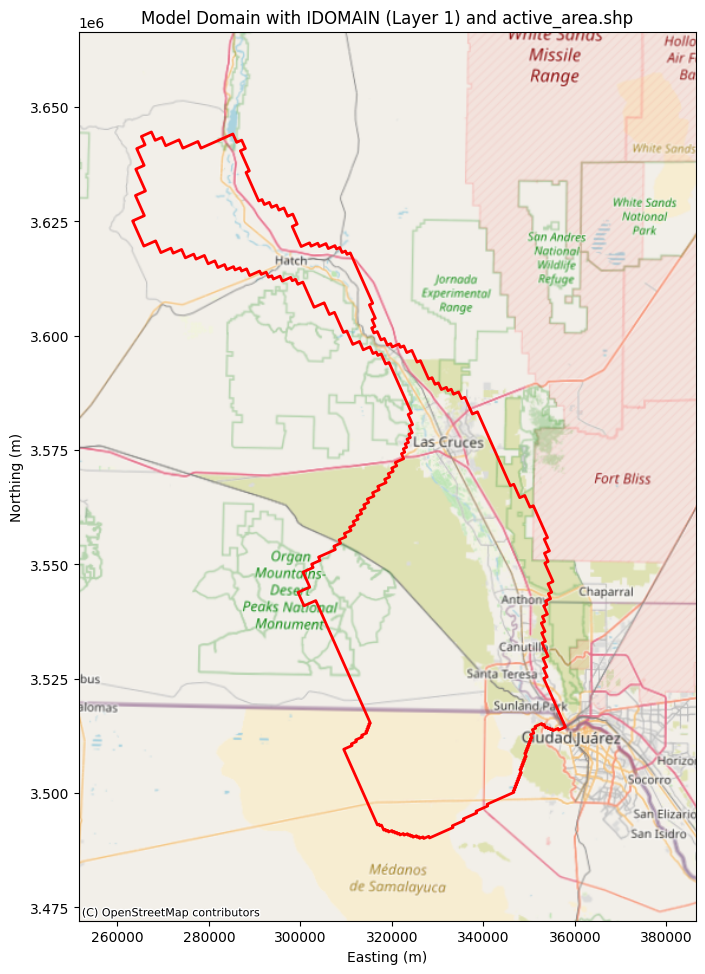

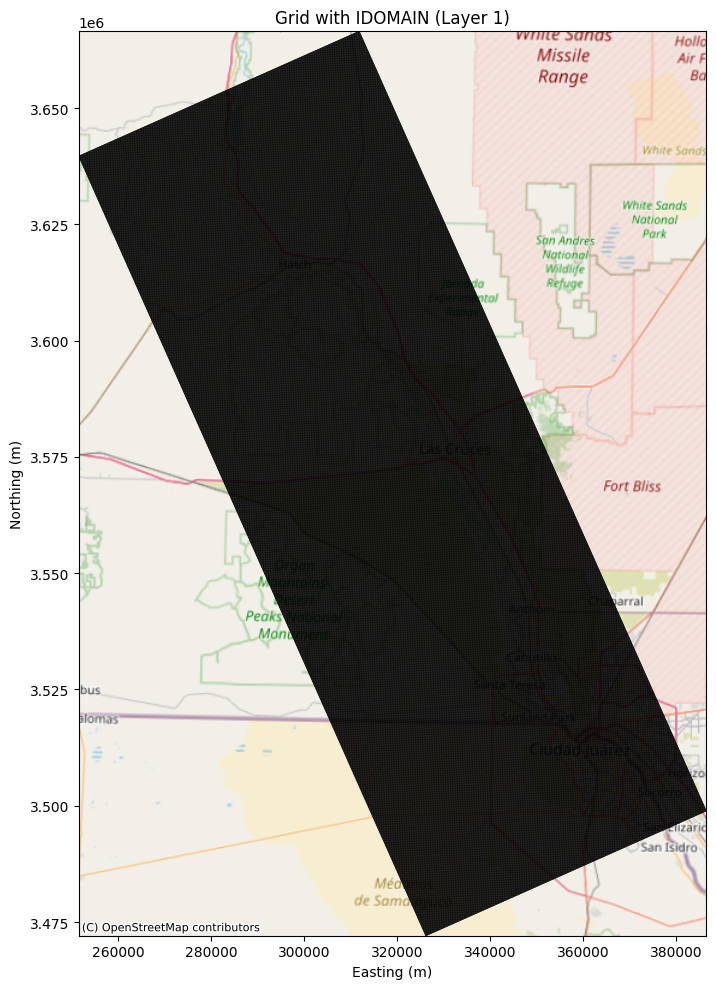

In [22]:
# Extract grid coordinates from DIS package
xll = dis.xorigin.get_data()  # Lower-left x (feet)
yll = dis.yorigin.get_data()  # Lower-left y (feet)
angrot = dis.angrot.get_data()  # Rotation angle in degrees
delr = dis.delr.get_data()  # Cell widths (array in feet)
delc = dis.delc.get_data()  # Cell heights (array in feet)
ncol = dis.ncol.get_data()  # Number of columns
nrow = dis.nrow.get_data()  # Number of rows
idomain = dis.idomain.get_data()  # 3D IDOMAIN array

# Compute rotated grid coordinates (edges, not centers, for extent)
x = np.arange(ncol + 1) * delr[0]  # +1 for edges (in feet)
y = np.arange(nrow + 1) * delc[0]  # +1 for edges (in feet)
X, Y = np.meshgrid(x, y)
X_rot = xll + X * np.cos(np.radians(angrot)) - Y * np.sin(np.radians(angrot))  # in feet
Y_rot = yll + X * np.sin(np.radians(angrot)) + Y * np.cos(np.radians(angrot))  # in feet

# Convert coordinates to meters for plotting (EPSG:26913 expects meters)
X_rot_m = X_rot * 0.3048  # Convert feet to meters
Y_rot_m = Y_rot * 0.3048  # Convert feet to meters
xll_m = xll * 0.3048  # Convert xll to meters
yll_m = yll * 0.3048  # Convert yll to meters

# Load active area shapefile
gdf = gpd.read_file('./shps/active_area.shp')
if gdf.crs != model_crs:
    gdf = gdf.to_crs(model_crs)

# 1. Overall model domain with IDOMAIN and shapefile
fig, ax = plt.subplots(figsize=(10, 10))
# Use IDOMAIN for layer 0 (Python index 0, MODFLOW layer 1)
ax.imshow(idomain[0], extent=[X_rot_m.min(), X_rot_m.max(), Y_rot_m.min(), Y_rot_m.max()], 
          cmap='binary', alpha=0.5)
gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2)
cx.add_basemap(ax, crs=model_crs, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_title('Model Domain with IDOMAIN (Layer 1) and active_area.shp')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
plt.tight_layout()
plt.show()

# 2. Grid outline with IDOMAIN
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.cm.colors.ListedColormap(['white', 'lightgrey'])
bounds = [0, 1, 2]
norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
ax.imshow(idomain[0], extent=[X_rot_m.min(), X_rot_m.max(), Y_rot_m.min(), Y_rot_m.max()], 
          cmap=cmap, norm=norm, alpha=0.8, interpolation='nearest')
gdf.plot(ax=ax, edgecolor='lightgrey', facecolor='none', linewidth=2, alpha=0.5)

# Plot grid lines using edge coordinates in meters
for i in range(nrow + 1):  # +1 for edges
    ax.plot(X_rot_m[i, :], Y_rot_m[i, :], 'k-', lw=0.5)
for j in range(ncol + 1):  # +1 for edges
    ax.plot(X_rot_m[:, j], Y_rot_m[:, j], 'k-', lw=0.5)

cx.add_basemap(ax, crs=model_crs, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_title('Grid with IDOMAIN (Layer 1)')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
plt.tight_layout()
plt.show()

# sample row and col XS

MF-OWHM row 538 -> MODFLOW 6 row 374
MF-OWHM row 741 -> MODFLOW 6 row 171
MF-OWHM row 103 -> MODFLOW 6 row 809
MF-OWHM col 75 -> MODFLOW 6 col 74
botm shape: (9, 912, 328)
top shape: (912, 328)
x_rot shape: (913, 329)
y_rot shape: (913, 329)
Row OWHM 538 (MF6 374), Layer top rc2: contains exact -99999=True, close to -99999=True
Row OWHM 538 (MF6 374), Layer top usf1: contains exact -99999=True, close to -99999=True
Row OWHM 538 (MF6 374), Layer top usf2: contains exact -99999=True, close to -99999=True
Row OWHM 538 (MF6 374), Layer top msf1: contains exact -99999=True, close to -99999=True
Row OWHM 538 (MF6 374), Layer top msf2: contains exact -99999=True, close to -99999=True
Row OWHM 538 (MF6 374), Layer top lsf1: contains exact -99999=True, close to -99999=True
Row OWHM 538 (MF6 374), Layer top lsf2: contains exact -99999=True, close to -99999=True
Row OWHM 538 (MF6 374), Layer top bsmt: contains exact -99999=True, close to -99999=True
Row OWHM 538 (MF6 374), Layer bsmt_botm: contai

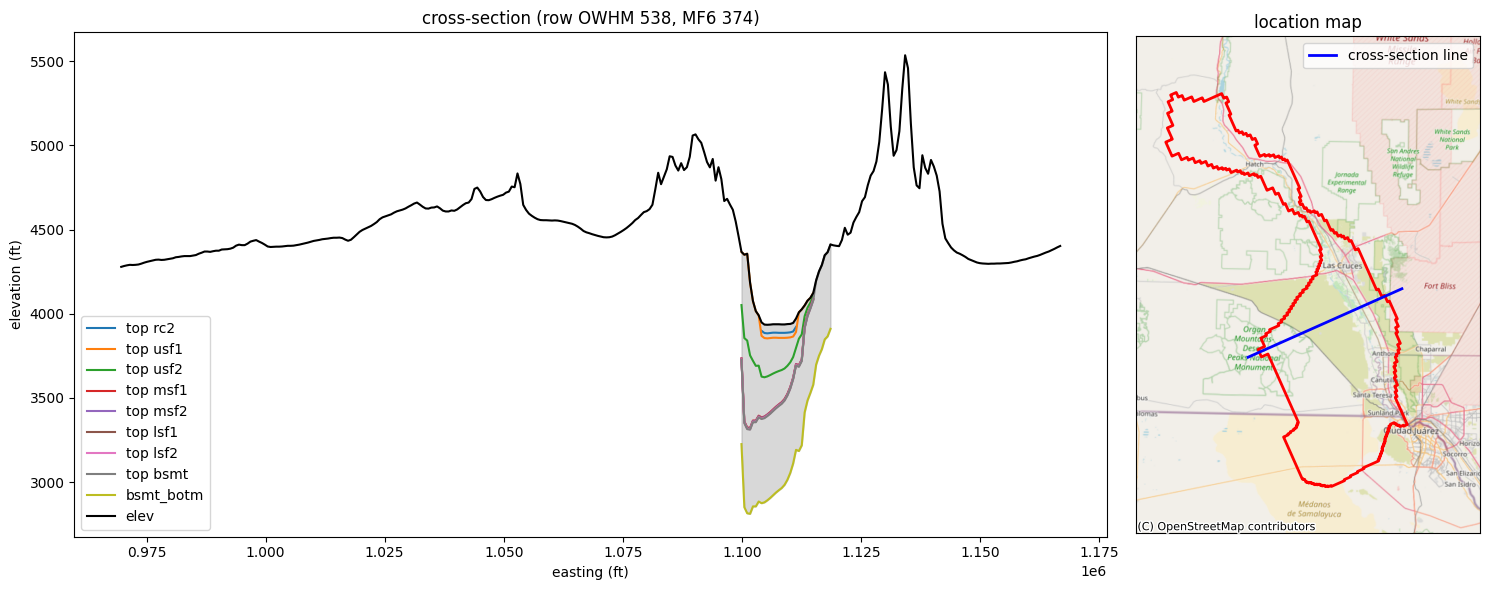

Row OWHM 741 (MF6 171), Layer top rc2: contains exact -99999=True, close to -99999=True
Row OWHM 741 (MF6 171), Layer top usf1: contains exact -99999=True, close to -99999=True
Row OWHM 741 (MF6 171), Layer top usf2: contains exact -99999=True, close to -99999=True
Row OWHM 741 (MF6 171), Layer top msf1: contains exact -99999=True, close to -99999=True
Row OWHM 741 (MF6 171), Layer top msf2: contains exact -99999=True, close to -99999=True
Row OWHM 741 (MF6 171), Layer top lsf1: contains exact -99999=True, close to -99999=True
Row OWHM 741 (MF6 171), Layer top lsf2: contains exact -99999=True, close to -99999=True
Row OWHM 741 (MF6 171), Layer top bsmt: contains exact -99999=True, close to -99999=True
Row OWHM 741 (MF6 171), Layer bsmt_botm: contains exact -99999=True, close to -99999=True
Row OWHM 741 (MF6 171), Top: contains exact -99999=False, close to -99999=False
inactive cells in row OWHM 741 (MF6 171): [('top rc2', 98), ('top usf1', 98), ('top usf2', 98), ('top msf1', 98), ('top

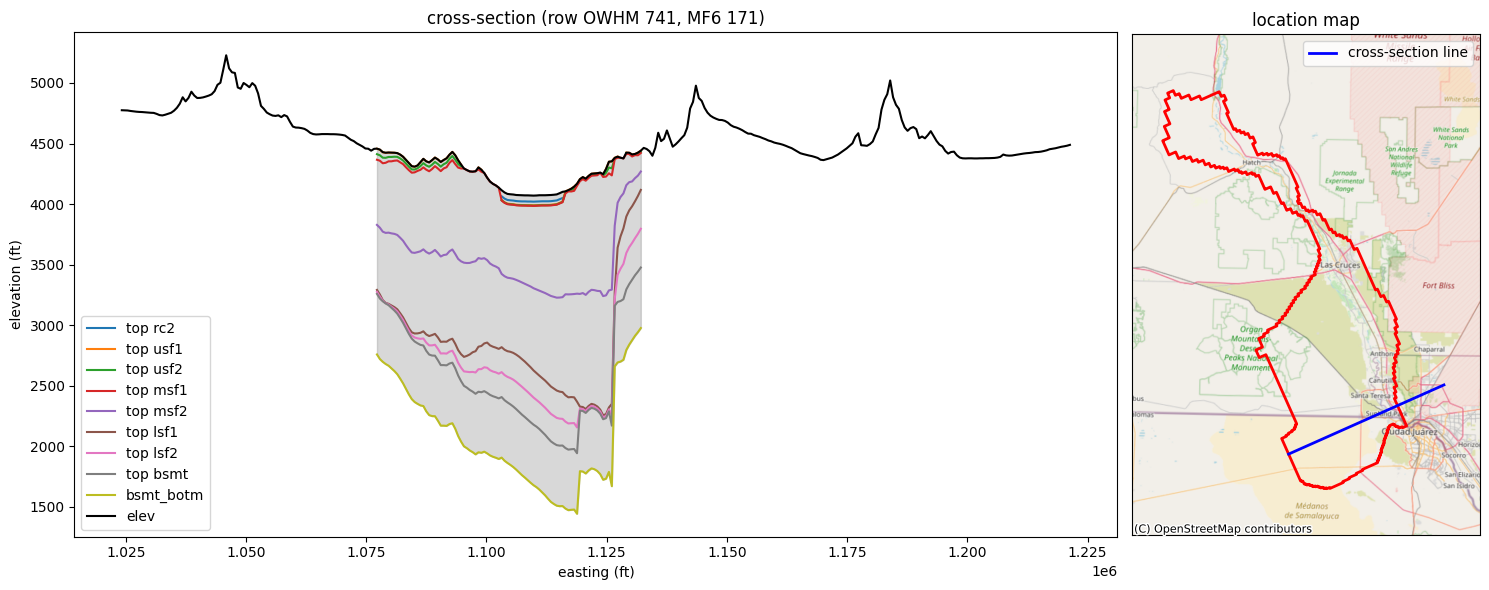

Row OWHM 103 (MF6 809), Layer top rc2: contains exact -99999=True, close to -99999=True
Row OWHM 103 (MF6 809), Layer top usf1: contains exact -99999=True, close to -99999=True
Row OWHM 103 (MF6 809), Layer top usf2: contains exact -99999=True, close to -99999=True
Row OWHM 103 (MF6 809), Layer top msf1: contains exact -99999=True, close to -99999=True
Row OWHM 103 (MF6 809), Layer top msf2: contains exact -99999=True, close to -99999=True
Row OWHM 103 (MF6 809), Layer top lsf1: contains exact -99999=True, close to -99999=True
Row OWHM 103 (MF6 809), Layer top lsf2: contains exact -99999=True, close to -99999=True
Row OWHM 103 (MF6 809), Layer top bsmt: contains exact -99999=True, close to -99999=True
Row OWHM 103 (MF6 809), Layer bsmt_botm: contains exact -99999=True, close to -99999=True
Row OWHM 103 (MF6 809), Top: contains exact -99999=False, close to -99999=False
inactive cells in row OWHM 103 (MF6 809): [('top rc2', 194), ('top usf1', 194), ('top usf2', 194), ('top msf1', 194), (

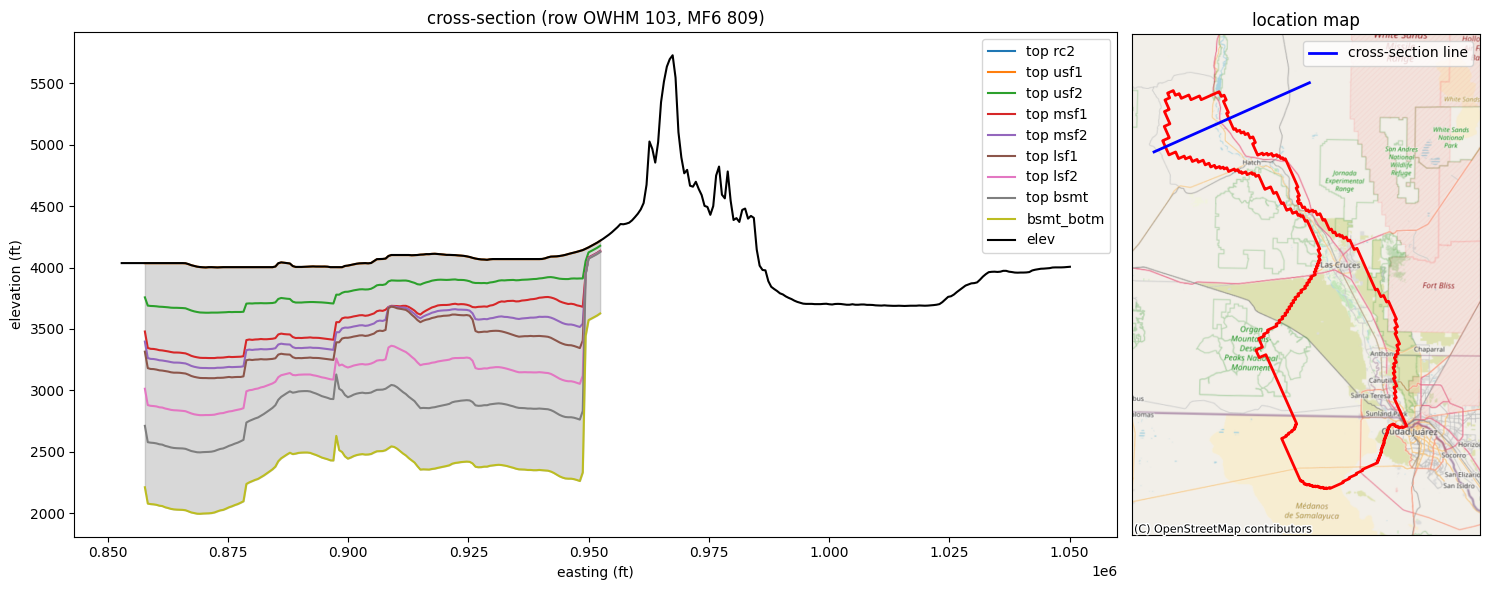

Col OWHM 75 (MF6 74), Layer top rc2: contains exact -99999=True, close to -99999=True
Col OWHM 75 (MF6 74), Layer top usf1: contains exact -99999=True, close to -99999=True
Col OWHM 75 (MF6 74), Layer top usf2: contains exact -99999=True, close to -99999=True
Col OWHM 75 (MF6 74), Layer top msf1: contains exact -99999=True, close to -99999=True
Col OWHM 75 (MF6 74), Layer top msf2: contains exact -99999=True, close to -99999=True
Col OWHM 75 (MF6 74), Layer top lsf1: contains exact -99999=True, close to -99999=True
Col OWHM 75 (MF6 74), Layer top lsf2: contains exact -99999=True, close to -99999=True
Col OWHM 75 (MF6 74), Layer top bsmt: contains exact -99999=True, close to -99999=True
Col OWHM 75 (MF6 74), Layer bsmt_botm: contains exact -99999=True, close to -99999=True
Col OWHM 75 (MF6 74), Top: contains exact -99999=False, close to -99999=False
inactive cells in column OWHM 75 (MF6 74): [('top rc2', 440), ('top usf1', 440), ('top usf2', 440), ('top msf1', 440), ('top msf2', 440), (

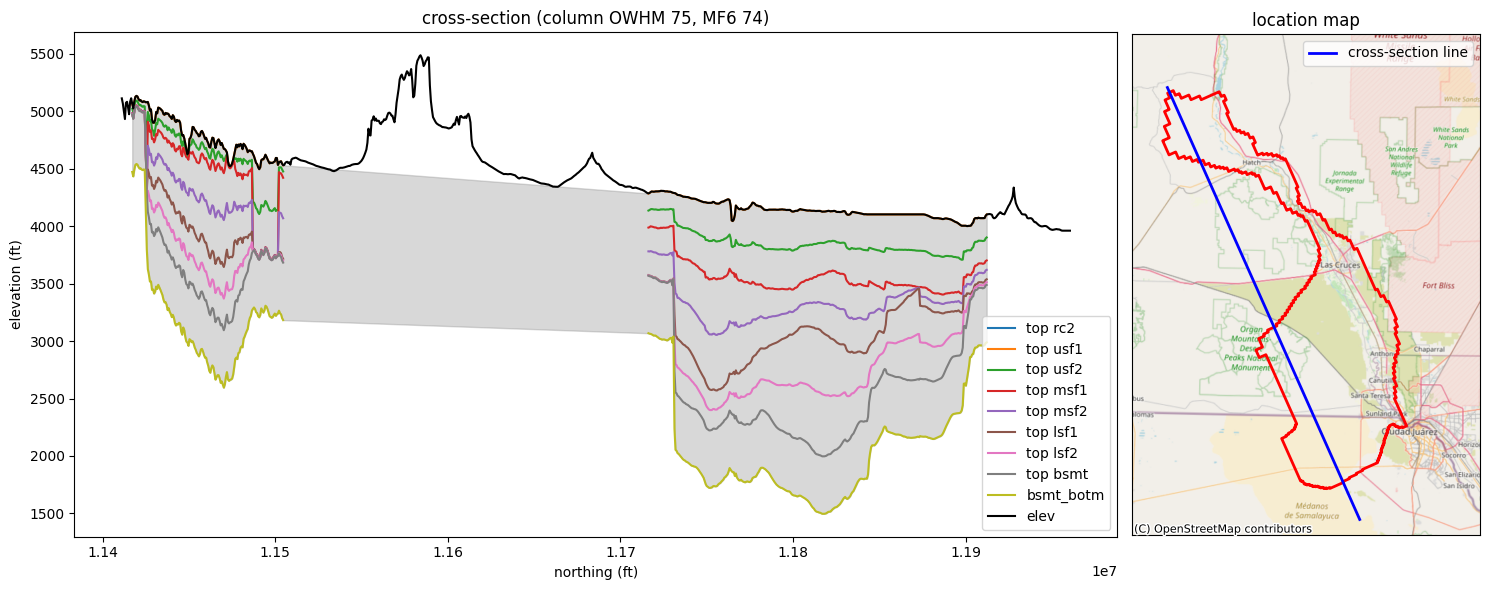

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx

# Cross-sections for rows 538, 741, 103 (MF-OWHM convention), and column 75 (MF-OWHM convention)
rows_owhm = [538, 741, 103]  # 1-based, top-down (MF-OWHM)
col_owhm = 75  # 1-based (MF-OWHM)

# Convert MF-OWHM indices to MODFLOW 6 indices
# Assuming nrow_owhm and ncol_owhm are defined (from DIS setup)
nrow_owhm = 912
ncol_owhm = 328

# Transform rows (top-down, 1-based to bottom-up, 0-based)
rows_mf6 = [nrow_owhm - 1 - (row - 1) for row in rows_owhm]
# Transform column (1-based to 0-based, no flipping needed for columns)
col_mf6 = col_owhm - 1

# Print the conversions for reference
for row_owhm, row_mf6 in zip(rows_owhm, rows_mf6):
    print(f"MF-OWHM row {row_owhm} -> MODFLOW 6 row {row_mf6}")
print(f"MF-OWHM col {col_owhm} -> MODFLOW 6 col {col_mf6}")

layer_names = ["top rc2", "top usf1", "top usf2", 
               "top msf1", "top msf2", "top lsf1", "top lsf2", 
               "top bsmt", "bsmt_botm"]

print("botm shape:", botm.shape)
print("top shape:", top.shape)
print("x_rot shape:", X_rot.shape)
print("y_rot shape:", Y_rot.shape)

# No-data sentinel in feet (corrected from -30479.6952 meters)
no_data_sentinel = -99999
tolerance = 1.0  # tolerance in feet to catch floating-point variations

# Debug function to check for sentinel values
def check_sentinel(data, sentinel, label):
    close_to_sentinel = np.any(np.abs(data - sentinel) < tolerance)
    exact_sentinel = np.any(data == sentinel)
    print(f"{label}: contains exact {sentinel}={exact_sentinel}, close to {sentinel}={close_to_sentinel}")

# Plot cross-sections for each row
for row_owhm, row_mf6 in zip(rows_owhm, rows_mf6):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [3, 1]})

    x_trimmed = X_rot[row_mf6, :ncol]
    for lay, name in zip(range(nlay), layer_names):
        bot = botm[lay, row_mf6, :]
        check_sentinel(bot, no_data_sentinel, f"Row OWHM {row_owhm} (MF6 {row_mf6}), Layer {name}")
        bot_plot = np.where(np.abs(bot - no_data_sentinel) < tolerance, np.nan, bot)
        ax1.plot(x_trimmed, bot_plot, label=name)

    top_data = top[row_mf6, :]
    check_sentinel(top_data, no_data_sentinel, f"Row OWHM {row_owhm} (MF6 {row_mf6}), Top")
    top_plot = np.where(np.abs(top_data - no_data_sentinel) < tolerance, np.nan, top_data)
    ax1.plot(x_trimmed, top_plot, 'k-', label='elev')

    inactive_cells = [(name, (idomain[lay, row_mf6, :] == 0).sum()) for lay, name in enumerate(layer_names)]
    print(f"inactive cells in row OWHM {row_owhm} (MF6 {row_mf6}): {inactive_cells}")

    botm_base = np.where(np.abs(botm[-1, row_mf6, :] - no_data_sentinel) < tolerance, np.nan, botm[-1, row_mf6, :])
    top_fill = np.where(np.abs(top[row_mf6, :] - no_data_sentinel) < tolerance, np.nan, top[row_mf6, :])
    valid_mask = ~np.isnan(botm_base) & ~np.isnan(top_fill)
    ax1.fill_between(x_trimmed[valid_mask], botm_base[valid_mask], top_fill[valid_mask], color='gray', alpha=0.3)

    ax1.set_title(f'cross-section (row OWHM {row_owhm}, MF6 {row_mf6})')
    ax1.set_xlabel('easting (ft)')  # Changed to feet to match data
    ax1.set_ylabel('elevation (ft)')  # Changed to feet to match data
    ax1.legend()

    # Convert to meters for location map
    ax2.imshow(idomain[0], extent=[X_rot.min() * 0.3048, X_rot.max() * 0.3048, Y_rot.min() * 0.3048, Y_rot.max() * 0.3048], 
               cmap='binary', alpha=0.5)
    gdf.plot(ax=ax2, edgecolor='red', facecolor='none', linewidth=2)
    cx.add_basemap(ax=ax2, crs=model_crs, source=cx.providers.OpenStreetMap.Mapnik)
    ax2.plot(X_rot[row_mf6, :] * 0.3048, Y_rot[row_mf6, :] * 0.3048, 'b-', lw=2, label='cross-section line')
    ax2.set_title('location map')
    ax2.legend()
    ax2.set_xticks([])
    ax2.set_yticks([])
    plt.tight_layout()
    plt.show()

# Plot cross-section for the column
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [3, 1]})

y_trimmed = Y_rot[:nrow, col_mf6]
for lay, name in zip(range(nlay), layer_names):
    bot = botm[lay, :, col_mf6]
    check_sentinel(bot, no_data_sentinel, f"Col OWHM {col_owhm} (MF6 {col_mf6}), Layer {name}")
    bot_plot = np.where(np.abs(bot - no_data_sentinel) < tolerance, np.nan, bot)
    ax1.plot(y_trimmed, bot_plot, label=name)

top_data = top[:, col_mf6]
check_sentinel(top_data, no_data_sentinel, f"Col OWHM {col_owhm} (MF6 {col_mf6}), Top")
top_plot = np.where(np.abs(top_data - no_data_sentinel) < tolerance, np.nan, top_data)
ax1.plot(y_trimmed, top_plot, 'k-', label='elev')

inactive_cells_col = [(name, (idomain[lay, :, col_mf6] == 0).sum()) for lay, name in enumerate(layer_names)]
print(f"inactive cells in column OWHM {col_owhm} (MF6 {col_mf6}): {inactive_cells_col}")

botm_base = np.where(np.abs(botm[-1, :, col_mf6] - no_data_sentinel) < tolerance, np.nan, botm[-1, :, col_mf6])
top_fill = np.where(np.abs(top[:, col_mf6] - no_data_sentinel) < tolerance, np.nan, top[:, col_mf6])
valid_mask = ~np.isnan(botm_base) & ~np.isnan(top_fill)
ax1.fill_between(y_trimmed[valid_mask], botm_base[valid_mask], top_fill[valid_mask], color='gray', alpha=0.3)

ax1.set_title(f'cross-section (column OWHM {col_owhm}, MF6 {col_mf6})')
ax1.set_xlabel('northing (ft)')  # Changed to feet to match data
ax1.set_ylabel('elevation (ft)')  # Changed to feet to match data
ax1.legend()

# Convert to meters for location map
ax2.imshow(idomain[0], extent=[X_rot.min() * 0.3048, X_rot.max() * 0.3048, Y_rot.min() * 0.3048, Y_rot.max() * 0.3048], 
           cmap='binary', alpha=0.5)
gdf.plot(ax=ax2, edgecolor='red', facecolor='none', linewidth=2)
cx.add_basemap(ax=ax2, crs=model_crs, source=cx.providers.OpenStreetMap.Mapnik)
ax2.plot(X_rot[:, col_mf6] * 0.3048, Y_rot[:, col_mf6] * 0.3048, 'b-', lw=2, label='cross-section line')
ax2.set_title('location map')
ax2.legend()
ax2.set_xticks([])
ax2.set_yticks([])
plt.tight_layout()
plt.show()